# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


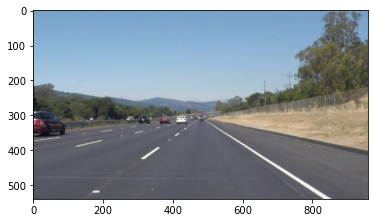

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    rm = []
    lm = []
    rc = []
    lc = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            center = [(x2+x1)/2, (y2+y1)/2]
            if 0.3<slope<1:
                rm.append(slope)
                rc.append(center)
            elif -1<slope<-0.3:
                lm.append(slope)
                lc.append(center)
            else:
                #do nothing
                print('Idle')
    
    if len(rm)!=0 and len(lm)!=0 and len(rc)!=0 and len(lc)!=0: 
        r_slope = np.sum(rm)/len(rm)
        l_slope = np.sum(lm)/len(lm)
        print(r_slope)
        print(l_slope)

        r_center = np.divide(np.sum(rc,axis=0),len(rc))
        l_center = np.divide(np.sum(lc,axis=0),len(lc))

        half = int(img.shape[0]/1.7)
        height = img.shape[0]
        r_x1 = int(r_center[0] - (r_center[1]-half)/r_slope)
        r_x2 = int(r_center[0] - (r_center[1]-height)/r_slope)

        l_x1 = int(l_center[0] - (l_center[1]-half)/l_slope)
        l_x2 = int(l_center[0] - (l_center[1]-height)/l_slope)

        r_int = np.array(r_center, int)
        l_int = np.array(l_center, int)

        cv2.line(img, (r_x1, half), (r_x2, height), color, thickness)
        cv2.line(img, (l_x1, half), (l_x2, height), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    print(lines)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    if lines is not None:
        draw_lines(line_img, lines)
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

(540, 960, 3)
[[[507 325 875 538]]

 [[626 387 897 537]]

 [[512 325 536 338]]

 [[280 460 344 410]]

 [[530 338 807 498]]

 [[295 462 353 413]]

 [[838 505 898 538]]

 [[411 366 420 359]]

 [[586 365 646 399]]

 [[309 449 345 419]]

 [[537 338 594 370]]]
0.561380579072365
-0.809297174329502
(540, 960, 3)
[[[502 319 854 538]]

 [[573 369 781 505]]

 [[764 495 831 539]]

 [[563 356 853 537]]

 [[495 317 634 408]]

 [[310 422 354 392]]

 [[318 426 363 394]]

 [[769 498 819 530]]

 [[332 408 349 396]]

 [[332 417 362 395]]

 [[309 423 330 409]]]
0.6419226421154969
-0.6997623291740939
(540, 960, 3)
[[[356 402 442 337]]

 [[409 359 437 338]]

 [[605 392 649 419]]

 [[643 408 658 417]]

 [[343 408 426 347]]

 [[605 393 622 404]]

 [[613 391 657 416]]

 [[230 486 235 483]]

 [[350 405 362 397]]

 [[319 426 334 416]]

 [[495 322 507 329]]

 [[367 391 385 378]]

 [[548 356 558 362]]

 [[550 353 563 361]]

 [[302 436 307 433]]

 [[435 339 444 332]]

 [[493 323 506 330]]]
0.595757061565885
-0.697

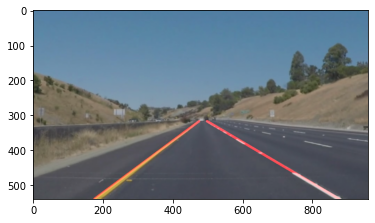

In [4]:
import os
files = os.listdir("test_images/")

for file in files:
    if file[0:6] != "output":
        img = mpimg.imread("test_images/" + file)
        
        img = gaussian_blur(img,3)
        # Grab the x and y size and make a copy of the image
        ysize = img.shape[0]
        xsize = img.shape[1]
        color_select = np.copy(img)

        # Define color selection criteria
        ###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
        red_threshold = 130
        green_threshold = 130
        blue_threshold = 130
        ######

        rgb_threshold = [red_threshold, green_threshold, blue_threshold]

        # Do a boolean or with the "|" character to identify
        # pixels below the thresholds
        thresholds = (img[:,:,0] < rgb_threshold[0]) \
                    | (img[:,:,1] < rgb_threshold[1]) \
                    | (img[:,:,2] < rgb_threshold[2])
        color_select[thresholds] = [0,0,0]
        
        gray = grayscale(color_select)
        #gray = grayscale(img)
        edges = canny(gray,50,150)
        plt.imshow(edges)
        #plt.imshow(color_select)
        
        imshape = img.shape
        print(imshape)
        
        vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),\
                              (0, imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)
        target = region_of_interest(edges, vertices)
        
        lines = hough_lines(target,1,np.pi/180,35,5,2)
        
        result = weighted_img(lines,img,α=0.8, β=1.)
        
        plt.imshow(result, cmap='gray')
        
        r,g,b = cv2.split(result)
        result = cv2.merge((b,g,r))
        
        cv2.imwrite("test_images/output_" + file, result)
        




# Display the image                 
#plt.imshow(color_select)


        

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


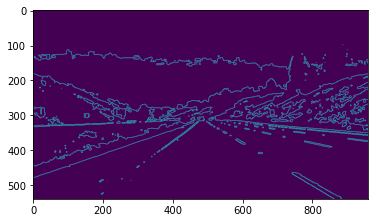

In [5]:
print(edges)
plt.imshow(edges)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [24]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
   # binary_output = np.copy(img) # placeholder line
    return binary_output

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    image = np.copy(img)
    img = gaussian_blur(img,3)
    
    print(img.shape)
    
   # img2 = np.copy(img)
    
    hls_binary = hls_select(img, thresh=(90, 255))
   # hls_binary = hls_select(img, thresh=(30, 255))
   # edges = hls_binary
   # print(edges)

    gray = grayscale(image)
    gray = gaussian_blur(gray,3)
    #canny_binary = canny(gray,50,150)
    
    gray_canny = canny(gray,50,150)

    canny_binary = np.zeros_like(gray)
    canny_binary[(gray_canny >= 200)] = 1
    
   # red = img[:,:,0] #Red Channel
    #gray = gaussian_blur(gray,3)
    #canny_binary = canny(red,50,150)
    #plt.imshow(edges)
   # plt.imshow(color_select)
     
    combined_binary = np.zeros_like(gray)
    combined_binary[(hls_binary == 1) | (canny_binary == 1)] = 1
    edges = combined_binary
    print(edges)
    print(canny_binary)
    print(hls_binary)
    
   # edges = canny_binary
  #  img = gaussian_blur(img,3)
#     ysize = img.shape[0]
#     xsize = img.shape[1]
#     color_select = np.copy(img)

#     # Define color selection criteria
#     ###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
#     red_threshold = 80
#     green_threshold = 80
#     blue_threshold = 80
#     ######

#     rgb_threshold = [red_threshold, green_threshold, blue_threshold]

#     # Do a boolean or with the "|" character to identify
#     # pixels below the thresholds
#     thresholds = (img[:,:,0] < rgb_threshold[0]) \
#                 | (img[:,:,1] < rgb_threshold[1]) \
#                 | (img[:,:,2] < rgb_threshold[2])
#     color_select[thresholds] = [0,0,0]

    #gray = grayscale(color_select)
    #gray = grayscale(img)
    #gray = gaussian_blur(gray,3)
  #  edges = canny(gray,50,150)
    #plt.imshow(edges)
   # plt.imshow(color_select)
    
    imshape = img.shape
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58), \
                          (0, imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)
    target = region_of_interest(edges, vertices)

    lines = hough_lines(target,1,np.pi/180,35,5,2)

    result = weighted_img(lines,image,α=0.8, β=1.)
    
    return result


    
# Optional TODO - tune the threshold to try to match the above image!    


Let's try the one with the solid white lane on the right first ...

In [38]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|█▏                                                                   | 4/221 [00:00<00:05, 38.56it/s, now=None]

(540, 960, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[715 446 870 539]]

 [[632 395 870 538]]

 [[492 314 697 442]]

 [[200 515 246 481]]

 [[187 513 300 431]]

 [[230 494 310 432]]

 [[686 436 808 513]]

 [[546 344 642 400]]

 [[399 364 406 359]]

 [[721 459 848 539]]

 [[448 325 453 321]]

 [[452 326 470 313]]

 [[271 463 311 432]]

 [[514 325 571 358]]

 [[628 399 712 452]]

 [[388 368 403 357]]

 [[598 375 668 416]]

 [[447 326 457 319]]]
0.6072496388093414
-0.7427372690486709
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

(540, 960, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ..

t:  10%|██████▊                                                             | 22/221 [00:00<00:03, 53.01it/s, now=None]

[[[496 316 742 470]]

 [[572 364 850 538]]

 [[627 392 813 503]]

 [[525 330 632 396]]

 [[326 410 363 384]]

 [[448 329 471 313]]

 [[333 413 370 385]]

 [[408 354 419 346]]

 [[335 412 370 386]]

 [[326 411 365 384]]

 [[822 507 873 538]]

 [[808 499 873 539]]

 [[327 413 333 409]]

 [[454 324 468 314]]]
0.6147899861387646
-0.7123126970953058
(540, 960, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[517 326 595 373]]

 [[548 345 864 535]]

 [[570 363 796 505]]

 [[599 382 849 538]]

 [[496 316 587 373]]

 [[310 422 356 390]]

 [[408 357 417 351]]

 [[318 424 362 392]]

 [[643 402 871 539]]

 [[449 328 470 313]]

 [[445 328 459 318]]

 [[323 420 361 391]]

 [[406 355 416 

t:  14%|█████████▌                                                          | 31/221 [00:00<00:03, 59.42it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[515 326 854 538]]

 [[496 317 692 445]]

 [[621 399 812 524]]

 [[720 465 833 539]]

 [[244 479 327 419]]

 [[232 476 320 417]]

 [[688 435 827 522]]

 [[560 358 632 405]]

 [[573 362 693 437]]

 [[262 455 317 418]]

 [[453 326 469 315]]

 [[245 478 272 458]]

 [[451 325 465 315]]

 [[394 365 407 356]]

 [[456 325 473 313]]]
0.6416320761176869
-0.7008487355902753
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 

t:  22%|██████████████▊                                                     | 48/221 [00:00<00:02, 67.40it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[541 342 687 434]]

 [[568 360 840 530]]

 [[653 421 833 538]]

 [[146 538 252 464]]

 [[166 538 240 483]]

 [[563 361 694 447]]

 [[144 539 250 465]]

 [[498 317 558 356]]

 [[255 473 264 466]]

 [[218 500 264 465]]

 [[600 386 834 538]]

 [[383 378 400 365]]

 [[167 537 179 528]]

 [[452 326 470 314]]

 [[753 475 855 538]]

 [[379 376 397 363]]

 [[453 326 472 313]]

 [[197 516 214 503]]

 [[424 346 430 341]]]
0.6398350349022669
-0.7386634595480538
(540, 960, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ..

t:  29%|███████████████████▋                                                | 64/221 [00:00<00:02, 71.84it/s, now=None]

(540, 960, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[617 395 831 539]]

 [[512 324 728 459]]

 [[539 343 783 507]]

 [[698 441 853 538]]

 [[515 328 629 404]]

 [[350 390 378 372]]

 [[354 393 380 375]]

 [[348 390 375 373]]

 [[448 327 470 313]]

 [[416 349 423 344]]

 [[374 378 380 374]]

 [[441 329 451 322]]]
0.6525002924164471
-0.6688729260157832
(540, 960, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0

t:  37%|████████████████████████▉                                           | 81/221 [00:01<00:01, 75.46it/s, now=None]


[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[600 388 747 487]]

 [[527 338 825 539]]

 [[507 325 522 335]]

 [[620 395 822 522]]

 [[701 447 846 538]]

 [[509 323 598 381]]

 [[331 408 366 384]]

 [[452 324 469 313]]

 [[451 323 456 320]]

 [[322 408 360 382]]

 [[408 354 418 348]]

 [[508 322 633 403]]

 [[490 313 564 364]]

 [[322 406 356 384]]

 [[407 351 415 346]]]
0.6574757949185459
-0.6412917798698426
(540, 960, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 

t:  45%|██████████████████████████████▍                                     | 99/221 [00:01<00:01, 80.53it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[519 334 812 539]]

 [[545 349 733 472]]

 [[558 361 811 538]]

 [[268 448 333 404]]

 [[257 446 328 402]]

 [[639 411 789 509]]

 [[528 337 644 413]]

 [[710 458 833 538]]

 [[394 362 407 354]]

 [[452 324 469 313]]

 [[489 313 543 350]]

 [[269 448 333 405]]

 [[257 447 298 421]]]
0.6710880288114679
-0.6441843611932789
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ..

t:  49%|████████████████████████████████▋                                  | 108/221 [00:01<00:01, 80.98it/s, now=None]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[699 457 812 539]]

 [[638 407 832 538]]

 [[117 539 248 454]]

 [[517 326 752 496]]

 [[136 538 259 455]]

 [[751 483 778 501]]

 [[559 353 744 478]]

 [[380 375 398 363]]

 [[213 487 244 466]]

 [[547 344 684 437]]

 [[458 321 471 313]]

 [[221 482 230 476]]

 [[250 462 259 456]]

 [[375 373 395 360]]

 [[165 520 206 492]]]
0.6909166938704557
-0.6610425010323508
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1

t:  57%|██████████████████████████████████████▏                            | 126/221 [00:01<00:01, 81.67it/s, now=None]


0.6697898584941775
-0.6504511035183304
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[543 344 807 528]]

 [[616 387 805 514]]

 [[569 361 823 538]]

 [[416 351 426 344]]

 [[576 361 752 479]]

 [[783 498 843 538]]

 [[449 326 466 315]]

 [[348 398 379 377]]

 [[457 324 475 313]]

 [[414 349 422 344]]

 [[533 334 595 375]]

 [[343 395 373 375]]

 [[512 324 547 348]]

 [[259 453 267 448]]

 [[342 396 361 384]]]
0.6785576547206142
-0.64797936293929
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 

t:  61%|████████████████████████████████████████▉                          | 135/221 [00:01<00:01, 81.34it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[526 335 838 538]]

 [[517 326 777 488]]

 [[629 403 836 538]]

 [[302 429 353 395]]

 [[764 479 828 520]]

 [[410 360 420 353]]

 [[501 319 637 407]]

 [[448 330 472 313]]

 [[411 360 420 354]]

 [[313 430 359 397]]

 [[784 491 859 538]]

 [[406 358 417 351]]

 [[457 327 475 315]]

 [[302 430 354 395]]]
0.6400403919929175
-0.6793956496402149
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]


t:  69%|██████████████████████████████████████████████                     | 152/221 [00:01<00:00, 73.44it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[549 350 759 487]]

 [[517 326 859 539]]

 [[552 348 816 513]]

 [[683 438 838 539]]

 [[525 334 674 431]]

 [[286 444 345 403]]

 [[295 446 352 405]]

 [[457 327 470 318]]

 [[448 330 467 316]]

 [[470 319 479 313]]

 [[404 362 411 357]]

 [[286 445 323 419]]

 [[434 340 439 337]]

 [[412 360 418 355]]

 [[448 331 463 320]]]
0.6405615169120029
-0.7093685047743923
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[517 326 859 5

t:  76%|███████████████████████████████████████████████████▏               | 169/221 [00:02<00:00, 75.38it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[573 359 850 539]]

 [[663 410 861 533]]

 [[561 348 716 444]]

 [[546 343 610 384]]

 [[262 461 338 408]]

 [[272 463 343 410]]

 [[274 463 343 411]]

 [[814 503 871 538]]

 [[292 439 335 409]]

 [[606 381 812 515]]

 [[403 361 416 352]]

 [[453 325 469 313]]

 [[437 340 442 337]]

 [[262 462 290 442]]

 [[460 324 475 313]]

 [[590 365 622 385]]

 [[528 332 556 350]]

 [[449 328 467 314]]]
0.6329236402470352
-0.7162849419007034
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 

t:  81%|█████████████████████████████████████████████████████▉             | 178/221 [00:02<00:00, 77.66it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[625 389 885 539]]

 [[537 341 864 538]]

 [[703 442 862 538]]

 [[704 435 822 503]]

 [[175 538 204 516]]

 [[202 532 220 517]]

 [[227 512 300 453]]

 [[525 330 570 357]]

 [[210 512 288 453]]

 [[544 342 599 375]]

 [[221 516 273 474]]

 [[212 511 245 486]]

 [[201 518 208 512]]

 [[279 471 291 461]]

 [[430 345 436 341]]

 [[457 328 465 322]]

 [[498 318 540 342]]

 [[255 479 277 462]]

 [[392 374 407 363]]

 [[562 357 863 538]]

 [[458 324 467 317]]

 [[218 518 228 510]]

 [[521 328 634 395]]

 [[397 376 411 365]]

 [[468 321 479 313]]]
0.5916769067239112
-0.7766137360448295
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1

t:  89%|███████████████████████████████████████████████████████████▍       | 196/221 [00:02<00:00, 80.19it/s, now=None]


[[[654 403 887 538]]

 [[685 427 851 530]]

 [[618 386 734 458]]

 [[642 395 668 410]]

 [[548 341 774 472]]

 [[517 326 586 366]]

 [[373 387 395 370]]

 [[789 491 863 537]]

 [[428 349 436 342]]

 [[380 389 400 372]]

 [[453 327 471 313]]

 [[772 472 887 539]]

 [[584 366 619 387]]

 [[373 388 396 370]]

 [[458 326 470 317]]]
0.5956755868152981
-0.8013522910262041
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[602 373 887 538]]

 [[585 367 727 453]]

 [[749 466 865 538]]

 [[510 323 595 372]]

 [[730 455 864 538]]

 [[653 402 705 432]]

 [[364 394 388 375]]

 [[425 351 433 345]]

 [[546 340 622 384]]

 [[453 328 470 313]]

 [[371 396 395 377]]

 [[423 349 431

t:  97%|████████████████████████████████████████████████████████████████▉  | 214/221 [00:02<00:00, 80.93it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[711 435 896 538]]

 [[550 346 763 473]]

 [[584 363 722 440]]

 [[717 445 875 539]]

 [[324 424 369 391]]

 [[504 321 573 360]]

 [[334 426 364 401]]

 [[525 330 583 361]]

 [[335 426 373 394]]

 [[570 355 631 388]]

 [[658 405 804 486]]

 [[459 326 475 314]]

 [[452 330 460 324]]

 [[767 474 874 538]]

 [[416 357 425 350]]

 [[450 328 466 316]]]
0.566613081079725
-0.7766499582289056
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[511 324 897 538]]

 [[508 325 876 538]]

 [[260 488 315 443]]

 [[248 486 301 444]]

 [[295 459 307 449]]

 [[308 448 339 423]]

 [[292 450 330 421]]

 [[282 458 314 434]]

 [[448 333 465 320]]

 [[405 369 417 360]]

 [[457 329 468 321]]

 [[401 366 414 357]]

 [[248 485 280 460]]]
0.5666042464519035
-0.770828526479751
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[548 345 897 539]]

 [[508 325 876 538]]

 [[219 522 323 43

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [40]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▍                                                                    | 4/681 [00:00<00:17, 38.93it/s, now=None]

(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[105 538 422 348]]

 [[118 539 449 332]]

 [[120 539 427 347]]

 [[137 518 422 346]]

 [[122 539 288 435]]

 [[669 426 759 486]]

 [[115 539 391 367]]

 [[658 427 758 497]]

 [[124 539 190 498]]

 [[563 357 580 369]]

 [[114 539 338 399]]

 [[663 425 690 444]]

 [[563 360 577 369]]

 [[660 425 688 445]]

 [[116 539 418 351]]

 [[111 539 278 435]]

 [[675 433 691 444]]

 [[231 462 269 439]]

 [[661 425 688 444]]

 [[108 539 213 474]]

 [[566 357 581 367]]

 [[565 357 577 365]]

 [[711 457 722 464]]

 [[673 435 687 445]]

 [[666 425 690 441]]

 [[563 359 578 369]]

 [[670 436 716 468]]

 [[422 345 446 330]]]
0.68250449

t:   3%|█▉                                                                  | 20/681 [00:00<00:12, 51.58it/s, now=None]


0.6637451868544305
-0.6726706961810034
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[121 539 436 342]]

 [[124 539 402 365]]

 [[126 539 393 372]]

 [[120 539 411 357]]

 [[128 539 376 384]]

 [[129 539 348 402]]

 [[132 539 290 440]]

 [[120 538 405 360]]

 [[123 539 420 353]]

 [[134 539 263 458]]

 [[135 539 234 477]]

 [[610 387 655 416]]

 [[137 539 190 506]]

 [[616 387 659 415]]

 [[612 390 627 400]]

 [[633 400 654 414]]

 [[388 369 427 344]]

 [[609 389 624 399]]

 [[643 405 655 413]]

 [[553 350 564 357]]

 [[617 390 658 417]]

 [[610 389 652 417]]

 [[139 539 171 519]]]
0.6582045322449936
-0.6266434044289652
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 

t:   5%|███▌                                                                | 36/681 [00:00<00:10, 61.86it/s, now=None]

[[[140 539 419 351]]

 [[135 539 439 334]]

 [[142 539 400 365]]

 [[138 539 430 342]]

 [[133 539 423 343]]

 [[145 539 342 406]]

 [[147 539 302 434]]

 [[148 539 261 463]]

 [[150 539 233 483]]

 [[624 390 675 422]]

 [[619 390 672 423]]

 [[617 391 664 422]]

 [[153 539 181 520]]

 [[633 398 670 421]]

 [[818 510 827 515]]

 [[133 538 243 464]]

 [[625 390 676 421]]

 [[655 413 670 423]]

 [[661 418 668 423]]

 [[552 347 560 353]]

 [[134 539 428 341]]

 [[144 539 374 384]]

 [[152 539 213 498]]]
0.6472932948106317
-0.6745527959929742
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[153 539 427 340]]

 [[142 539 378 374]]

 [[279 450 440 333]]

 [[424 341 442 

t:   6%|████▍                                                               | 44/681 [00:00<00:09, 66.26it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[165 539 426 342]]

 [[161 539 429 337]]

 [[158 539 382 371]]

 [[167 539 408 357]]

 [[150 539 350 394]]

 [[195 519 383 377]]

 [[148 539 258 460]]

 [[163 539 439 331]]

 [[157 539 333 407]]

 [[156 539 297 433]]

 [[654 407 713 442]]

 [[659 407 735 452]]

 [[652 409 691 433]]

 [[424 338 436 329]]

 [[668 417 701 436]]

 [[652 410 733 460]]

 [[160 539 412 349]]

 [[147 539 195 504]]

 [[154 539 260 460]]

 [[164 538 428 339]]

 [[653 407 676 421]]]
0.6004078993457224
-0.7466540240510556
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 

t:   9%|█████▉                                                              | 59/681 [00:00<00:09, 66.52it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[162 539 447 324]]

 [[147 539 436 329]]

 [[164 539 408 355]]

 [[160 539 419 344]]

 [[149 539 410 349]]

 [[158 539 399 358]]

 [[654 412 749 471]]

 [[669 415 762 469]]

 [[145 539 211 491]]

 [[560 353 575 362]]

 [[660 411 693 432]]

 [[156 539 344 398]]

 [[197 516 207 508]]

 [[253 474 274 458]]

 [[155 539 227 483]]

 [[655 411 684 427]]

 [[295 431 302 426]]

 [[181 527 367 387]]

 [[146 539 280 442]]

 [[664 411 679 420]]

 [[683 425 693 431]]

 [[734 456 743 461]]

 [[676 423 694 433]]

 [[212 495 287 440]]

 [[346 405 351 401]]]
0.5889885198083391
-0.7505108408605802
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1

t:  11%|███████▍                                                            | 74/681 [00:01<00:09, 65.07it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[146 539 410 354]]

 [[144 539 432 337]]

 [[138 539 436 330]]

 [[142 539 415 348]]

 [[141 539 425 340]]

 [[149 539 357 393]]

 [[150 539 339 407]]

 [[153 539 264 461]]

 [[695 434 719 448]]

 [[660 420 756 480]]

 [[739 464 754 473]]

 [[698 439 704 442]]

 [[735 463 763 480]]

 [[718 447 757 470]]

 [[761 476 768 480]]

 [[709 445 735 461]]

 [[702 443 761 480]]

 [[136 539 253 457]]

 [[561 353 578 364]]

 [[660 419 754 478]]

 [[155 539 190 515]]

 [[746 469 764 480]]

 [[670 418 698 435]]

 [[530 335 537 339]]

 [[661 417 672 423]]

 [[145 539 422 345]]

 [[668 420 673 423]]

 [[137 539 277 441]]

 [[679 427 689 433]]

 [[161 534 224 490]]

 [[709 446 727 457]]

 [[675 422 689 431]]

 [[741 464 756 473]]

 [[148 539 373 381]]

 [[762 474 

t:  12%|████████                                                            | 81/681 [00:01<00:09, 64.87it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[157 539 451 325]]

 [[143 539 424 342]]

 [[155 539 426 342]]

 [[245 477 391 371]]

 [[141 539 296 431]]

 [[153 539 396 363]]

 [[151 539 337 404]]

 [[557 352 574 362]]

 [[139 539 218 484]]

 [[555 354 570 364]]

 [[676 434 730 468]]

 [[652 412 742 466]]

 [[164 535 439 335]]

 [[648 412 668 425]]

 [[147 539 247 467]]

 [[711 450 725 459]]

 [[644 414 726 465]]

 [[558 353 573 363]]

 [[556 356 568 364]]

 [[675 428 688 436]]

 [[675 430 694 442]]

 [[149 539 287 439]]

 [[713 451 721 456]]

 [[674 429 695 441]]

 [[711 453 720 459]]

 [[152 539 360 388]]]
0.631623720497492
-0.718571533153784
(540, 960, 3)
[[1 1 1 ... 1 1 

t:  14%|█████████▋                                                          | 97/681 [00:01<00:08, 70.01it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[145 539 449 326]]

 [[142 539 418 346]]

 [[140 539 441 328]]

 [[139 539 443 326]]

 [[147 539 397 364]]

 [[137 539 362 382]]

 [[136 539 325 407]]

 [[149 539 327 414]]

 [[659 415 751 472]]

 [[134 539 263 449]]

 [[144 539 418 347]]

 [[716 460 738 474]]

 [[646 414 722 465]]

 [[131 539 210 484]]

 [[151 539 184 516]]

 [[130 538 181 503]]

 [[558 352 572 361]]

 [[150 539 197 506]]

 [[650 411 672 424]]

 [[687 441 736 474]]

 [[514 326 523 332]]

 [[649 417 666 428]]

 [[555 355 569 363]]]
0.6354856853866526
-0.6985717314529077
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]

t:  17%|███████████                                                        | 113/681 [00:01<00:07, 72.15it/s, now=None]


0.6392177553512516
-0.676258710056801
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[411 352 447 326]]

 [[146 539 421 346]]

 [[151 539 436 339]]

 [[143 539 376 376]]

 [[150 539 445 332]]

 [[154 539 359 395]]

 [[140 539 312 419]]

 [[147 539 417 350]]

 [[725 458 839 529]]

 [[682 441 821 531]]

 [[780 495 806 511]]

 [[746 474 775 493]]

 [[703 445 727 460]]

 [[757 483 771 492]]

 [[138 539 266 450]]

 [[156 539 224 491]]

 [[689 441 696 445]]

 [[777 491 830 524]]

 [[137 539 236 470]]

 [[567 360 585 371]]

 [[511 325 523 333]]

 [[691 441 697 445]]

 [[135 539 197 496]]

 [[756 482 765 488]]

 [[718 458 725 463]]

 [[152 539 402 364]]

 [[788 501 805 

t:  19%|████████████▋                                                      | 129/681 [00:01<00:07, 73.13it/s, now=None]

[[[154 539 427 341]]

 [[156 539 465 315]]

 [[195 513 422 348]]

 [[158 539 423 347]]

 [[152 539 349 396]]

 [[281 452 468 316]]

 [[150 539 334 406]]

 [[732 461 794 499]]

 [[716 460 837 538]]

 [[143 539 312 421]]

 [[140 539 261 455]]

 [[719 454 745 470]]

 [[138 539 210 489]]

 [[801 504 856 537]]

 [[526 333 532 337]]

 [[147 539 258 459]]

 [[537 340 543 344]]

 [[569 365 586 376]]

 [[827 523 832 526]]

 [[620 397 625 400]]

 [[513 326 524 333]]

 [[695 446 765 493]]

 [[736 467 748 474]]

 [[572 362 591 374]]

 [[287 449 295 443]]

 [[784 496 796 503]]

 [[535 342 542 346]]

 [[694 447 717 462]]

 [[336 413 394 371]]

 [[536 343 541 346]]

 [[786 499 792 502]]

 [[770 488 775 491]]

 [[155 539 461 317]]

 [[755 476 791 498]]

 [[815 516 821 520]]

 [[738 469 747 475]]

 [[784 497 791 501]]

 [[571 362 590 374]]]
0.6179333486153394
-0.7203438947995123
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ...

t:  20%|█████████████▍                                                     | 137/681 [00:01<00:07, 74.08it/s, now=None]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[162 539 419 352]]

 [[151 539 420 351]]

 [[149 539 471 314]]

 [[146 539 371 382]]

 [[235 488 301 440]]

 [[756 485 838 538]]

 [[379 382 468 319]]

 [[144 539 298 432]]

 [[157 539 292 444]]

 [[775 486 861 538]]

 [[494 316 509 325]]

 [[142 539 205 495]]

 [[163 539 378 383]]

 [[153 539 387 375]]

 [[582 368 602 381]]

 [[750 482 806 518]]

 [[509 324 528 336]]

 [[463 322 470 317]]

 [[164 539 411 360]]

 [[775 487 820 514]]

 [[148 539 451 327]]

 [[542 343 549 348]]

 [[576 370 595 382]]

 [[154 539 347 404]]]
0.6356992642316701
-0.7079784167360731
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 .

t:  22%|███████████████                                                    | 153/681 [00:02<00:07, 73.63it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[149 539 401 363]]

 [[396 370 441 338]]

 [[434 340 467 316]]

 [[156 539 383 380]]

 [[147 539 430 341]]

 [[153 539 427 347]]

 [[159 539 322 425]]

 [[158 539 353 402]]

 [[161 539 265 466]]

 [[146 539 349 397]]

 [[144 539 266 454]]

 [[155 539 397 369]]

 [[162 539 242 483]]

 [[151 539 419 351]]

 [[664 426 669 429]]

 [[583 374 608 390]]

 [[586 372 615 388]]

 [[843 527 862 538]]

 [[143 539 204 496]]

 [[185 532 191 528]]

 [[440 340 467 319]]

 [[542 347 550 352]]

 [[491 318 516 331]]

 [[544 345 552 350]]

 [[502 320 512 326]]]
0.5925839382940109
-0.70535590424283
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]


t:  25%|████████████████▋                                                  | 169/681 [00:02<00:06, 75.65it/s, now=None]

[[[150 538 440 342]]

 [[152 539 453 336]]

 [[150 539 432 349]]

 [[157 539 350 409]]

 [[154 539 447 341]]

 [[155 539 432 352]]

 [[192 509 448 336]]

 [[167 539 299 446]]

 [[159 539 331 423]]

 [[161 539 313 436]]

 [[603 383 637 402]]

 [[598 385 630 404]]

 [[168 539 255 478]]

 [[497 324 519 336]]

 [[309 429 371 387]]

 [[162 539 276 462]]

 [[494 319 521 335]]

 [[599 383 616 393]]

 [[598 384 631 404]]

 [[621 395 635 404]]

 [[551 352 561 358]]

 [[195 521 222 502]]

 [[513 329 521 334]]

 [[549 354 558 359]]]
0.5908329266049854
-0.6813257719757063
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[151 538 431 349]]

 [[155 539 445 343]]

 [[153 539 452 

t:  27%|██████████████████▏                                                | 185/681 [00:02<00:06, 72.50it/s, now=None]


0.5709224288687652
-0.7494468458588084
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[167 539 412 367]]

 [[161 539 433 348]]

 [[165 539 426 356]]

 [[176 539 395 380]]

 [[163 539 440 345]]

 [[178 539 357 409]]

 [[168 539 378 392]]

 [[181 539 238 497]]

 [[559 356 569 362]]

 [[533 341 538 344]]

 [[814 509 820 512]]

 [[626 396 677 426]]

 [[563 354 574 360]]

 [[170 539 323 432]]

 [[631 394 669 415]]

 [[559 353 565 356]]

 [[180 539 328 431]]

 [[505 322 524 333]]

 [[391 376 425 353]]

 [[496 321 522 335]]

 [[338 416 360 400]]

 [[449 336 465 325]]

 [[493 316 514 328]]

 [[678 420 683 423]]

 [[175 539 223 503]]

 [[650 405 657 409]]

 [[244 493 255

t:  28%|██████████████████▉                                                | 193/681 [00:02<00:06, 71.65it/s, now=None]


0.5368015784244775
-0.7528535171070756
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[177 539 428 350]]

 [[190 539 464 325]]

 [[175 539 353 405]]

 [[187 539 432 348]]

 [[192 539 389 385]]

 [[185 539 377 389]]

 [[650 409 693 433]]

 [[189 539 431 350]]

 [[493 322 522 337]]

 [[246 499 287 467]]

 [[562 355 574 362]]

 [[634 401 673 423]]

 [[183 539 324 429]]

 [[676 418 700 431]]

 [[194 539 338 426]]

 [[493 318 523 335]]

 [[641 399 677 418]]

 [[173 539 238 490]]

 [[412 361 460 324]]

 [[505 327 512 331]]

 [[179 539 278 464]]

 [[659 409 669 415]]

 [[644 401 653 406]]

 [[869 528 879 533]]

 [[872 530 877 533]]

 [[186 539 405 368]]

 [[561 355 574

t:  31%|████████████████████▌                                              | 209/681 [00:02<00:06, 70.04it/s, now=None]


0.5524120661435543
-0.761560788510454
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[170 538 422 355]]

 [[172 539 386 383]]

 [[173 539 375 392]]

 [[218 502 454 330]]

 [[176 539 357 407]]

 [[183 539 349 414]]

 [[185 539 325 433]]

 [[556 358 567 364]]

 [[295 445 424 351]]

 [[187 539 280 469]]

 [[344 408 434 342]]

 [[633 403 696 439]]

 [[493 323 508 331]]

 [[366 391 452 328]]

 [[680 422 707 437]]

 [[515 331 520 334]]

 [[180 539 265 475]]

 [[557 355 568 361]]

 [[647 405 654 409]]

 [[635 401 650 409]]

 [[483 315 509 329]]

 [[203 530 213 522]]

 [[169 538 447 336]]

 [[661 412 675 420]]

 [[699 432 704 435]]

 [[191 539 252 491]]

 [[633 401 688 

t:  33%|██████████████████████▏                                            | 225/681 [00:03<00:06, 71.94it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[174 539 423 351]]

 [[172 539 421 352]]

 [[170 539 450 328]]

 [[168 539 392 371]]

 [[177 539 447 335]]

 [[166 539 354 398]]

 [[179 539 352 408]]

 [[163 539 275 455]]

 [[175 539 451 331]]

 [[180 539 233 499]]

 [[624 400 681 434]]

 [[555 356 567 363]]

 [[160 539 222 493]]

 [[669 421 682 428]]

 [[668 420 683 428]]

 [[528 341 534 344]]

 [[494 325 514 336]]

 [[631 399 657 413]]

 [[165 539 326 418]]

 [[494 322 510 331]]

 [[164 539 308 431]]

 [[552 358 563 364]]

 [[159 538 190 516]]

 [[239 495 251 486]]

 [[162 539 247 475]]

 [[652 411 663 417]]

 [[857 535 863 538]]]
0.544862732960819
-0.7491764723939913
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0

t:  34%|██████████████████████▉                                            | 233/681 [00:03<00:06, 71.08it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[154 539 420 353]]

 [[173 539 434 343]]

 [[153 538 421 351]]

 [[213 510 450 331]]

 [[171 539 388 376]]

 [[169 539 358 397]]

 [[336 411 350 401]]

 [[167 539 338 411]]

 [[651 412 730 458]]

 [[494 321 501 325]]

 [[503 325 517 333]]

 [[166 539 315 427]]

 [[643 414 717 460]]

 [[163 539 275 455]]

 [[644 413 719 460]]

 [[158 539 255 469]]

 [[408 358 438 337]]

 [[290 453 356 404]]

 [[556 360 569 368]]

 [[497 325 508 331]]

 [[700 441 721 453]]

 [[559 358 575 368]]

 [[652 412 663 418]]

 [[350 399 401 364]]

 [[526 342 532 345]]

 [[172 539 405 364]]

 [[313 427 337 410]]

 [[481 313 489 318]]]
0.5834288491566973
-0.7299982728248228
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 .

t:  37%|████████████████████████▍                                          | 249/681 [00:03<00:06, 69.85it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[143 538 439 338]]

 [[143 539 429 346]]

 [[165 539 375 386]]

 [[145 539 413 358]]

 [[147 539 394 372]]

 [[307 426 417 352]]

 [[149 539 362 395]]

 [[152 539 325 422]]

 [[154 539 292 446]]

 [[655 417 739 471]]

 [[695 436 710 445]]

 [[663 416 694 434]]

 [[720 451 749 468]]

 [[156 539 231 490]]

 [[151 539 336 414]]

 [[528 337 535 341]]

 [[553 355 569 364]]

 [[160 539 219 499]]

 [[527 339 533 342]]

 [[379 376 430 341]]

 [[518 330 524 334]]

 [[668 420 686 430]]

 [[745 468 750 471]]

 [[556 353 571 361]]

 [[225 482 423 348]]

 [[484 313 505 325]]

 [[746 468 752 471]]

 [[182 527 211 506]]

 [[555 353 571 362]]

 [[157 538 245 480]]

 [[492 321 514 331]]

 [[229 493 240 485]]]
0.5658444902438228
-0.682945580627444
(540, 960, 3)
[[1

t:  38%|█████████████████████████▎                                         | 257/681 [00:03<00:05, 70.74it/s, now=None]

[[[198 516 454 323]]

 [[165 539 407 357]]

 [[162 539 347 400]]

 [[153 539 313 423]]

 [[273 462 425 348]]

 [[160 539 325 415]]

 [[164 539 378 378]]

 [[148 539 255 462]]

 [[152 539 291 438]]

 [[650 411 728 456]]

 [[308 437 454 327]]

 [[646 410 659 417]]

 [[642 413 713 457]]

 [[143 539 221 485]]

 [[155 539 281 447]]

 [[690 435 716 450]]

 [[437 335 453 323]]

 [[528 342 533 345]]

 [[650 417 706 452]]

 [[555 356 570 364]]

 [[150 539 272 451]]

 [[146 539 217 488]]

 [[167 539 439 334]]

 [[493 321 507 329]]

 [[219 501 421 349]]

 [[285 454 435 341]]

 [[553 357 566 365]]

 [[483 320 507 331]]

 [[664 420 681 430]]

 [[143 538 191 505]]]
0.5730673772513042
-0.7365746134967969
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 .

t:  40%|██████████████████████████▊                                        | 272/681 [00:03<00:06, 66.55it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[154 539 455 328]]

 [[156 539 430 347]]

 [[151 539 424 347]]

 [[159 539 372 390]]

 [[449 332 455 327]]

 [[152 539 419 352]]

 [[161 539 352 405]]

 [[162 539 332 420]]

 [[164 539 298 445]]

 [[166 539 270 466]]

 [[159 538 407 364]]

 [[627 402 684 439]]

 [[170 539 235 492]]

 [[152 537 225 486]]

 [[654 414 695 437]]

 [[553 357 565 364]]

 [[633 401 658 415]]

 [[228 484 429 343]]

 [[484 322 500 329]]

 [[168 539 218 504]]

 [[526 342 532 345]]

 [[555 355 569 363]]

 [[674 426 688 434]]

 [[627 403 681 438]]

 [[504 327 517 335]]

 [[468 316 473 313]]

 [[628 401 638 407]]

 [[478 314 508 330]]

 [[426 344 446 331]]

 [[497 327 515 336]]]
0.5638965376792473
-0.7010623814772105
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 

t:  42%|████████████████████████████▏                                      | 286/681 [00:04<00:05, 66.54it/s, now=None]


0.5516759476710443
-0.6808268706615235
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[162 539 453 327]]

 [[168 539 454 331]]

 [[166 539 402 368]]

 [[170 539 384 383]]

 [[160 539 428 345]]

 [[163 539 404 364]]

 [[156 539 303 433]]

 [[158 539 339 408]]

 [[154 539 251 469]]

 [[641 408 701 444]]

 [[171 539 263 472]]

 [[649 406 722 448]]

 [[164 539 411 360]]

 [[488 322 523 339]]

 [[674 428 711 450]]

 [[518 334 527 339]]

 [[152 538 183 516]]

 [[693 432 714 444]]

 [[153 539 225 487]]

 [[558 358 572 366]]

 [[561 357 575 364]]

 [[646 410 676 428]]

 [[532 342 537 345]]]
0.5654064044475003
-0.7239012820849239
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 

t:  43%|████████████████████████████▊                                      | 293/681 [00:04<00:06, 63.04it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[159 539 414 361]]

 [[155 539 429 347]]

 [[158 539 408 364]]

 [[162 539 382 385]]

 [[164 539 342 414]]

 [[172 539 276 463]]

 [[154 538 444 335]]

 [[167 539 294 450]]

 [[664 421 711 448]]

 [[635 410 701 450]]

 [[161 539 415 361]]

 [[174 539 245 487]]

 [[656 420 703 447]]

 [[489 325 516 340]]

 [[298 436 350 400]]

 [[687 435 702 444]]

 [[658 422 700 447]]

 [[259 434 296 434]]

 [[557 361 570 368]]

 [[298 437 303 437]]

 [[309 438 341 438]]

 [[553 362 568 370]]

 [[507 332 515 337]]

 [[666 425 680 433]]

 [[440 342 453 331]]

 [[317 435 342 435]]

 [[169 539 218 504]]

 [[157 539 407 364]]

 [[640 408 660 419]]

 

t:  45%|██████████████████████████████▎                                    | 308/681 [00:04<00:05, 66.84it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[221 504 411 361]]

 [[162 539 434 341]]

 [[174 539 410 361]]

 [[257 478 441 339]]

 [[172 539 419 353]]

 [[160 539 348 403]]

 [[158 539 305 433]]

 [[621 400 654 420]]

 [[156 539 263 462]]

 [[169 539 350 403]]

 [[844 525 853 530]]

 [[658 418 671 426]]

 [[622 400 655 419]]

 [[616 399 667 430]]

 [[555 356 567 363]]

 [[629 402 652 415]]

 [[155 539 238 479]]

 [[296 444 346 407]]

 [[351 401 362 393]]

 [[167 539 302 438]]

 [[839 526 848 531]]

 [[154 539 212 497]]

 [[844 527 852 531]]

 [[491 320 497 323]]

 [[489 322 495 325]]

 [[648 412 677 429]]

 [[171 539 309 435]]

 [[551 357 564 365]]

 [[526 342 532 346]]

 [[838 528 843 531]]

 [[616 400 662 428]]

 [[528 340 534 344]]

 [[645 415 653 420]]

 [[371 394 400 371]]

 [[619 397 

t:  48%|███████████████████████████████▉                                   | 324/681 [00:04<00:05, 70.66it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[164 539 451 323]]

 [[161 539 358 391]]

 [[159 539 333 408]]

 [[231 491 418 351]]

 [[151 539 309 425]]

 [[307 436 449 329]]

 [[150 539 283 443]]

 [[183 526 395 367]]

 [[642 412 713 456]]

 [[147 539 229 480]]

 [[694 436 725 455]]

 [[158 539 304 429]]

 [[647 409 683 429]]

 [[556 358 571 366]]

 [[651 410 663 417]]

 [[153 539 262 460]]

 [[498 320 518 332]]

 [[145 539 195 503]]

 [[496 323 518 334]]

 [[163 539 378 377]]

 [[527 341 533 344]]

 [[267 465 454 324]]

 [[641 411 702 449]]

 [[558 356 574 365]]

 [[166 539 201 512]]

 [[717 453 722 456]]

 [[560 361 569 366]]

 [[644 409 653 414]]

 [[202 511 421 346]]

 [[160 539 342 402]]

 [[674 425 696 437]]]
0.5676328738661154
-0.7444159182354475
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1

t:  50%|█████████████████████████████████▍                                 | 340/681 [00:04<00:04, 71.93it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[152 539 408 360]]

 [[148 538 445 330]]

 [[159 539 330 419]]

 [[150 539 409 358]]

 [[155 539 404 364]]

 [[161 539 316 430]]

 [[695 439 805 503]]

 [[700 449 769 492]]

 [[146 539 245 470]]

 [[789 493 796 497]]

 [[157 539 365 393]]

 [[164 539 256 474]]

 [[493 322 502 327]]

 [[562 362 582 373]]

 [[682 431 772 483]]

 [[670 432 677 436]]

 [[723 463 731 468]]

 [[561 364 577 374]]

 [[510 330 520 336]]

 [[672 432 699 448]]

 [[492 325 506 332]]

 [[531 343 538 347]]

 [[148 539 401 362]]

 [[671 432 696 447]]

 [[503 330 511 334]]

 [[163 539 278 458]]

 [[506 331 523 341]]

 [[503 327 523 339]]

 [[156 539 380 382]]

 

t:  51%|██████████████████████████████████▏                                | 348/681 [00:04<00:04, 69.23it/s, now=None]

0.5990998603844483
-0.6872700828949619
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[136 539 413 359]]

 [[137 537 438 341]]

 [[139 539 379 383]]

 [[142 539 343 408]]

 [[150 539 316 427]]

 [[746 471 773 487]]

 [[724 467 753 485]]

 [[785 498 799 506]]

 [[505 328 529 342]]

 [[196 498 411 358]]

 [[138 539 389 376]]

 [[244 466 413 356]]

 [[728 460 799 501]]

 [[810 511 836 526]]

 [[378 377 434 340]]

 [[143 539 234 482]]

 [[152 539 279 453]]

 [[569 370 586 380]]

 [[573 367 592 379]]

 [[811 514 825 523]]

 [[779 490 861 538]]

 [[759 481 772 489]]

 [[810 516 824 524]]

 [[782 500 800 511]]

 [[535 345 542 349]]

 [[811 515 824 523]]

 [[149 539 210 

t:  53%|███████████████████████████████████▋                               | 363/681 [00:05<00:04, 69.37it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[144 539 434 343]]

 [[155 539 424 351]]

 [[139 539 425 346]]

 [[141 539 413 355]]

 [[158 539 346 407]]

 [[683 440 808 521]]

 [[693 439 817 513]]

 [[367 388 416 354]]

 [[564 365 581 375]]

 [[146 539 383 379]]

 [[802 510 816 518]]

 [[724 466 820 528]]

 [[149 539 313 428]]

 [[746 475 762 485]]

 [[742 475 768 492]]

 [[688 441 696 446]]

 [[827 524 832 527]]

 [[469 313 474 316]]

 [[564 364 572 369]]

 [[303 438 312 432]]

 [[720 458 726 461]]

 [[783 497 798 506]]

 [[150 539 273 456]]

 [[804 509 820 518]]

 [[793 500 815 513]]

 [[750 479 767 490]]

 [[816 515 821 518]]

 [[567 363 582 372]]

 [[290 447 296 443]]

 [[569 363 586 373]]

 [[498 325 507 330]]

 [[789 503 796 507]]

 [[196 513 219 497]]

 [[746 473 757 480]]

 [[788 503 

t:  56%|█████████████████████████████████████▎                             | 379/681 [00:05<00:04, 71.71it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[160 539 431 342]]

 [[157 539 417 350]]

 [[154 539 428 340]]

 [[242 482 388 376]]

 [[429 338 442 328]]

 [[147 539 251 464]]

 [[150 539 295 434]]

 [[152 539 339 404]]

 [[512 336 517 339]]

 [[739 476 809 520]]

 [[764 481 808 507]]

 [[569 370 590 382]]

 [[142 539 224 482]]

 [[535 345 542 349]]

 [[751 484 837 538]]

 [[162 539 411 358]]

 [[571 370 591 382]]

 [[816 513 858 538]]

 [[151 539 318 418]]

 [[156 539 410 355]]

 [[143 539 236 474]]

 [[497 325 510 332]]

 [[531 347 539 351]]

 [[477 319 489 325]]

 [[140 539 194 502]]

 [[571 368 589 379]]

 [[766 483 805 506]]

 [[576 368 597 381]]

 [[783 498 789 501]]

 [[823 520 828 523]]

 [[784 496 790 500]]

 [[752 474 758 477]]

 [[489 324 509 334]]

 [[487 320 499 327]]

 [[534 345 

t:  57%|██████████████████████████████████████                             | 387/681 [00:05<00:04, 68.80it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[149 539 402 362]]

 [[416 350 439 334]]

 [[141 539 439 330]]

 [[143 539 404 356]]

 [[147 539 433 339]]

 [[151 539 285 448]]

 [[139 539 321 412]]

 [[146 539 410 354]]

 [[152 539 253 471]]

 [[137 539 195 498]]

 [[154 539 234 485]]

 [[578 375 605 392]]

 [[584 377 608 391]]

 [[486 318 508 331]]

 [[166 528 300 437]]

 [[580 373 610 389]]

 [[157 539 215 499]]

 [[218 492 368 387]]

 [[533 348 543 353]]

 [[534 346 544 351]]

 [[584 374 593 379]]

 [[480 319 505 332]]

 [[144 539 413 351]]

 [[829 531 840 538]]

 [[534 349 541 353]]

 [[174 524 181 524]]

 [[494 322 499 325]]]
Idle
0.5655048318684682
-0.6931681240987911
(

t:  59%|███████████████████████████████████████▌                           | 402/681 [00:05<00:04, 69.27it/s, now=None]

[[[133 539 435 335]]

 [[151 539 351 399]]

 [[135 539 419 348]]

 [[140 539 430 343]]

 [[137 539 414 353]]

 [[143 539 345 403]]

 [[141 539 381 377]]

 [[489 321 513 335]]

 [[155 539 189 515]]

 [[145 539 238 478]]

 [[519 336 524 339]]

 [[132 538 155 523]]

 [[585 377 602 387]]

 [[681 439 688 443]]

 [[227 487 253 470]]

 [[582 379 612 398]]

 [[508 329 514 333]]

 [[582 377 611 395]]

 [[603 387 617 396]]

 [[210 499 230 486]]

 [[251 470 280 450]]

 [[587 377 610 391]]

 [[190 513 207 502]]

 [[133 538 203 491]]

 [[539 348 547 353]]

 [[146 539 218 492]]

 [[536 349 545 355]]

 [[590 385 609 397]]

 [[200 506 219 494]]

 [[176 518 305 431]]

 [[583 377 595 384]]

 [[134 539 407 355]]

 [[540 348 548 353]]]
0.6176298997465316
-0.6685457057683734
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 

t:  61%|█████████████████████████████████████████                          | 418/681 [00:05<00:03, 70.63it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[136 539 435 337]]

 [[140 539 447 332]]

 [[138 539 416 352]]

 [[144 539 374 384]]

 [[147 539 288 444]]

 [[130 539 242 464]]

 [[133 539 340 400]]

 [[143 539 423 350]]

 [[520 337 525 340]]

 [[588 384 619 405]]

 [[492 320 516 335]]

 [[134 539 444 330]]

 [[478 314 483 317]]

 [[591 382 617 397]]

 [[538 352 549 358]]

 [[142 539 438 339]]

 [[128 539 197 493]]

 [[485 320 502 329]]

 [[594 385 602 390]]

 [[149 539 215 495]]

 [[469 313 478 318]]

 [[607 394 612 397]]

 [[484 315 509 331]]

 [[490 323 510 334]]

 [[608 395 615 399]]

 [[703 454 713 460]]

 [[519 339 524 342]]]
0.593079524593756
-0.6724607636306872
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0

t:  63%|█████████████████████████████████████████▉                         | 426/681 [00:06<00:03, 67.87it/s, now=None]


0.6148501952096305
-0.7000023520983577
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[143 539 447 334]]

 [[138 539 443 333]]

 [[145 539 430 347]]

 [[141 539 417 353]]

 [[150 539 332 416]]

 [[149 539 352 402]]

 [[136 539 316 418]]

 [[152 539 282 451]]

 [[135 539 222 480]]

 [[608 390 658 420]]

 [[154 539 231 487]]

 [[147 539 396 371]]

 [[604 392 651 422]]

 [[139 539 418 351]]

 [[606 391 614 396]]

 [[155 539 215 499]]

 [[627 404 639 412]]

 [[494 322 513 334]]

 [[545 354 556 361]]

 [[507 326 516 332]]

 [[604 393 633 412]]

 [[490 317 508 328]]

 [[548 352 560 360]]

 [[505 328 516 334]]

 [[780 494 785 497]]

 [[523 340 528 343]]]
0.626382963571

t:  65%|███████████████████████████████████████████▎                       | 440/681 [00:06<00:03, 67.03it/s, now=None]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[156 539 454 322]]

 [[152 539 374 378]]

 [[149 539 331 407]]

 [[175 526 417 350]]

 [[276 454 420 350]]

 [[145 539 296 430]]

 [[138 539 273 445]]

 [[155 539 459 318]]

 [[323 421 459 322]]

 [[137 539 239 468]]

 [[135 539 207 489]]

 [[140 539 281 440]]

 [[752 479 760 483]]

 [[633 404 639 408]]

 [[153 539 389 368]]

 [[607 393 647 419]]

 [[611 390 654 417]]

 [[495 318 515 330]]

 [[492 320 514 333]]

 [[266 452 317 416]]

 [[602 386 613 393]]

 [[646 413 654 418]]

 [[491 316 507 326]]

 [[487 318 494 322]]

 [[141 539 248 464]]

 [[150 539 343 399]]

 [[505 327 512 331]]

 [[612 390 632 402]]

 [[147 539 298 430]]

 [

t:  67%|████████████████████████████████████████████▊                      | 456/681 [00:06<00:03, 70.65it/s, now=None]


0.6031312030820195
-0.6744437208606358
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[147 539 411 355]]

 [[142 539 453 321]]

 [[145 539 414 351]]

 [[136 539 292 430]]

 [[138 539 320 412]]

 [[313 425 356 395]]

 [[133 539 235 468]]

 [[140 539 362 384]]

 [[155 535 449 329]]

 [[238 466 269 445]]

 [[143 539 450 324]]

 [[606 387 651 413]]

 [[544 352 554 358]]

 [[130 539 182 503]]

 [[762 489 769 493]]

 [[484 313 489 316]]

 [[605 387 644 410]]

 [[601 389 630 408]]

 [[488 315 515 331]]

 [[491 320 512 332]]

 [[762 490 767 493]]

 [[637 409 647 415]]

 [[752 488 763 495]]

 [[131 539 203 489]]

 [[546 350 557 357]]

 [[753 486 766 494]]

 [[135 539 271

t:  68%|█████████████████████████████████████████████▋                     | 464/681 [00:06<00:03, 71.13it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[133 539 460 318]]

 [[140 539 448 331]]

 [[137 539 412 353]]

 [[128 539 283 435]]

 [[131 539 388 366]]

 [[143 539 324 417]]

 [[134 539 395 363]]

 [[126 539 236 465]]

 [[546 352 558 359]]

 [[608 394 654 423]]

 [[500 324 515 333]]

 [[138 539 414 353]]

 [[823 530 829 534]]

 [[550 351 560 358]]

 [[142 539 383 376]]

 [[526 337 531 340]]

 [[615 392 662 420]]

 [[631 406 658 423]]

 [[163 527 206 498]]

 [[608 393 648 419]]

 [[548 354 556 359]]

 [[487 314 502 323]]

 [[487 318 497 324]]

 [[620 398 655 420]]

 [[493 317 517 332]]

 [[618 394 663 421]]

 [[124 539 158 516]]

 [[490 319 505 328]]

 [[624 400 640 410]]

 [[135 539 408 355]]]
0.6211400306859305
-0.6744524742368706
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 

t:  70%|███████████████████████████████████████████████▏                   | 480/681 [00:06<00:02, 69.92it/s, now=None]


-0.6571367663794827
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[152 539 416 354]]

 [[138 539 439 336]]

 [[142 539 404 362]]

 [[134 539 328 409]]

 [[136 539 355 392]]

 [[295 440 466 321]]

 [[132 539 253 458]]

 [[635 405 702 445]]

 [[627 406 692 448]]

 [[145 539 234 481]]

 [[486 316 491 319]]

 [[140 539 430 343]]

 [[263 462 288 445]]

 [[627 407 691 448]]

 [[143 539 374 383]]

 [[674 429 702 446]]

 [[482 313 508 329]]

 [[554 356 568 364]]

 [[145 538 264 460]]

 [[361 395 438 341]]

 [[511 333 516 336]]

 [[483 317 507 331]]

 [[147 539 207 500]]

 [[131 539 186 502]]

 [[528 341 534 344]]

 [[530 341 535 344]]

 [[484 318 494 324]]

 [[435 338 

t:  73%|████████████████████████████████████████████████▊                  | 496/681 [00:07<00:02, 71.88it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[158 539 449 328]]

 [[160 539 421 350]]

 [[155 539 355 394]]

 [[146 539 318 419]]

 [[420 348 427 343]]

 [[156 539 374 381]]

 [[377 385 406 364]]

 [[220 497 426 348]]

 [[153 539 320 418]]

 [[637 413 707 459]]

 [[144 539 276 447]]

 [[275 458 455 328]]

 [[645 412 695 442]]

 [[142 539 247 466]]

 [[680 437 696 447]]

 [[485 313 512 330]]

 [[639 412 651 419]]

 [[151 539 270 453]]

 [[140 539 195 501]]

 [[690 440 723 460]]

 [[678 437 695 447]]

 [[485 316 518 336]]

 [[646 415 652 419]]

 [[704 454 717 462]]

 [[641 412 650 418]]

 [[705 453 718 461]]

 [[638 413 649 419]]

 [[440 335 466 318]]

 [[644 412 687 438]]

 

t:  75%|██████████████████████████████████████████████████▎                | 512/681 [00:07<00:02, 72.41it/s, now=None]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[150 539 420 350]]

 [[147 539 446 330]]

 [[152 539 447 333]]

 [[435 342 460 325]]

 [[144 539 405 357]]

 [[155 539 346 405]]

 [[699 449 762 490]]

 [[688 434 770 484]]

 [[158 539 239 482]]

 [[142 539 292 434]]

 [[148 539 413 354]]

 [[533 342 540 346]]

 [[484 313 519 334]]

 [[527 337 534 341]]

 [[140 539 232 475]]

 [[500 320 523 334]]

 [[490 317 521 336]]

 [[567 360 584 370]]

 [[718 453 739 466]]

 [[489 313 507 324]]

 [[563 362 578 371]]

 [[563 361 580 371]]

 [[537 341 542 344]]

 [[156 539 326 420]]

 [[139 539 199 497]]

 [[670 430 736 474]]

 [[760 479 782 492]]

 [[160 539 195 514]]

 [[680 429 720 453]]

 [

t:  76%|███████████████████████████████████████████████████▏               | 520/681 [00:07<00:02, 70.83it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[147 539 397 370]]

 [[141 539 415 355]]

 [[144 539 416 356]]

 [[138 539 337 405]]

 [[140 539 400 364]]

 [[148 539 372 388]]

 [[150 539 347 406]]

 [[271 459 292 445]]

 [[135 539 265 452]]

 [[692 442 823 520]]

 [[683 443 805 522]]

 [[152 539 262 465]]

 [[396 365 467 320]]

 [[510 334 521 340]]

 [[154 539 217 497]]

 [[484 314 493 319]]

 [[773 491 819 519]]

 [[567 366 585 377]]

 [[488 317 522 339]]

 [[486 319 499 327]]

 [[145 539 441 340]]

 [[381 375 457 327]]

 [[514 337 520 341]]

 [[706 459 750 487]]

 [[531 347 538 351]]

 [[137 539 294 433]]

 [[342 409 363 395]]

 [[490 322 511 335]]

 [[287 448 307 434]]

 [[563 367 581 378]]

 [[429 349 454 332]]

 [[779 504 823 533]]

 [[143 539 416 355]]]
0.6135664034180334
-0.66972598848

t:  79%|████████████████████████████████████████████████████▋              | 535/681 [00:07<00:02, 67.96it/s, now=None]


0.6183489978285294
-0.6768968881553855
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[136 539 459 329]]

 [[176 510 454 329]]

 [[135 538 418 354]]

 [[140 539 361 395]]

 [[317 426 329 418]]

 [[147 539 282 451]]

 [[143 539 318 425]]

 [[145 539 296 441]]

 [[499 320 526 337]]

 [[713 452 854 537]]

 [[707 457 808 522]]

 [[497 322 524 339]]

 [[267 450 469 318]]

 [[150 539 231 487]]

 [[519 333 525 337]]

 [[138 539 386 378]]

 [[807 509 855 538]]

 [[794 512 835 538]]

 [[743 473 760 483]]

 [[142 539 351 403]]

 [[154 539 224 492]]

 [[148 539 270 460]]

 [[742 476 748 480]]

 [[155 539 208 503]]

 [[742 475 749 479]]

 [[570 365 590 377]]

 [[713 460 733

t:  80%|█████████████████████████████████████████████████████▍             | 543/681 [00:07<00:01, 69.02it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[154 539 458 326]]

 [[153 539 440 338]]

 [[155 539 420 354]]

 [[158 539 427 351]]

 [[151 539 403 363]]

 [[159 539 473 319]]

 [[149 539 365 388]]

 [[692 446 834 538]]

 [[145 539 273 450]]

 [[748 473 781 493]]

 [[147 539 310 425]]

 [[161 539 218 499]]

 [[144 539 253 463]]

 [[571 364 589 375]]

 [[714 452 737 466]]

 [[792 500 857 538]]

 [[142 539 217 487]]

 [[692 447 717 463]]

 [[504 325 515 332]]

 [[772 497 818 527]]

 [[737 465 747 471]]

 [[754 479 762 484]]

 [[703 445 740 467]]

 [[712 454 717 457]]

 [[499 321 513 330]]

 [[729 464 738 469]]

 [[300 454 349 414]]

 [[567 366 579 374]]

 [[505 322 521 332]]

 [[141 539 181 511]]

 [[537 346 542 349]]

 [[732 465 737 468]]

 [[516 330 527 337]]

 [[580 370 585 373]]

 [[851 535 

t:  82%|██████████████████████████████████████████████████████▉            | 559/681 [00:07<00:01, 70.88it/s, now=None]


0.6040177478835878
-0.684785740000606
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[158 539 433 346]]

 [[153 539 419 353]]

 [[148 539 323 417]]

 [[150 539 444 333]]

 [[155 539 429 348]]

 [[161 539 336 416]]

 [[775 485 818 511]]

 [[164 539 266 467]]

 [[746 476 843 539]]

 [[820 521 830 527]]

 [[159 539 362 397]]

 [[765 486 779 495]]

 [[434 344 473 316]]

 [[798 509 843 538]]

 [[829 517 864 538]]

 [[578 369 600 382]]

 [[145 539 211 493]]

 [[583 367 604 380]]

 [[497 317 517 329]]

 [[154 539 421 352]]

 [[812 510 820 515]]

 [[831 519 863 539]]

 [[751 477 761 483]]

 [[543 343 551 348]]

 [[496 317 503 321]]

 [[165 539 190 522]]

 [[788 500 800 

t:  84%|████████████████████████████████████████████████████████▌          | 575/681 [00:08<00:01, 70.84it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[171 539 457 324]]

 [[169 539 411 357]]

 [[159 539 363 391]]

 [[238 490 436 341]]

 [[168 539 379 380]]

 [[275 463 450 332]]

 [[155 539 296 437]]

 [[783 495 852 538]]

 [[361 400 460 326]]

 [[428 344 453 326]]

 [[546 343 553 347]]

 [[164 539 303 435]]

 [[150 539 213 494]]

 [[798 494 870 537]]

 [[152 539 244 473]]

 [[834 524 851 535]]

 [[268 459 314 425]]

 [[783 496 850 538]]

 [[586 369 600 377]]

 [[499 318 512 326]]

 [[837 525 852 534]]

 [[506 321 518 329]]

 [[793 496 798 499]]

 [[584 371 608 386]]

 [[590 370 613 384]]

 [[209 502 228 487]]

 [[542 345 551 350]]

 [[544 343 553 348]]

 [[163 539 219 496]]

 

t:  87%|██████████████████████████████████████████████████████████▏        | 591/681 [00:08<00:01, 71.33it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[183 539 427 349]]

 [[170 539 435 340]]

 [[172 539 447 332]]

 [[173 539 424 350]]

 [[185 539 434 345]]

 [[169 539 345 407]]

 [[341 419 387 383]]

 [[175 539 395 373]]

 [[167 539 276 457]]

 [[316 438 395 376]]

 [[861 524 886 539]]

 [[824 514 865 538]]

 [[592 369 620 385]]

 [[166 539 223 496]]

 [[177 539 354 405]]

 [[178 539 308 441]]

 [[590 372 615 387]]

 [[546 345 554 350]]

 [[603 376 620 386]]

 [[499 318 514 327]]

 [[456 328 472 315]]

 [[859 522 886 538]]

 [[452 330 462 322]]

 [[195 527 252 485]]

 [[454 333 476 315]]

 [[174 539 418 355]]]
0.5953277889746684
-0.7680910062071907
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 

t:  88%|██████████████████████████████████████████████████████████▉        | 599/681 [00:08<00:01, 72.19it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[169 538 469 320]]

 [[175 539 383 388]]

 [[169 539 424 354]]

 [[172 539 430 352]]

 [[183 539 365 402]]

 [[173 539 448 340]]

 [[216 503 424 352]]

 [[447 342 456 335]]

 [[185 539 308 446]]

 [[186 539 263 481]]

 [[499 321 522 335]]

 [[177 539 354 410]]

 [[552 349 562 355]]

 [[600 381 629 399]]

 [[179 539 294 455]]

 [[188 539 246 495]]

 [[501 319 509 324]]

 [[604 379 638 398]]

 [[601 381 633 400]]

 [[551 351 559 356]]

 [[600 379 625 393]]

 [[170 539 428 352]]

 [[505 322 524 333]]

 [[180 539 253 486]]

 [[441 346 469 324]]]
0.5967673561310161
-0.740425547857073
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]

t:  90%|████████████████████████████████████████████████████████████▌      | 615/681 [00:08<00:00, 71.86it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[184 539 401 370]]

 [[189 539 426 354]]

 [[187 539 453 331]]

 [[288 464 458 331]]

 [[175 539 360 400]]

 [[182 539 351 407]]

 [[187 538 407 366]]

 [[174 538 295 447]]

 [[197 534 276 474]]

 [[614 386 644 403]]

 [[193 539 244 500]]

 [[620 386 658 408]]

 [[616 386 662 412]]

 [[177 539 305 442]]

 [[557 353 567 359]]

 [[174 539 312 435]]

 [[614 388 647 408]]

 [[494 317 523 334]]

 [[558 351 569 357]]

 [[237 503 425 356]]

 [[617 389 656 412]]

 [[196 539 226 515]]

 [[509 323 525 332]]

 [[190 538 419 359]]

 [[217 520 256 490]]

 [[178 539 255 481]]

 [[514 327 525 333]]]
0.5746251609657078
-0.7712757748839483
(540, 960, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 

t:  93%|█████████████████████████████████████████████████████████████▉     | 630/681 [00:08<00:00, 68.63it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[211 533 449 333]]

 [[200 539 374 393]]

 [[250 502 432 349]]

 [[203 539 472 313]]

 [[190 539 319 435]]

 [[198 539 358 405]]

 [[196 539 316 438]]

 [[318 447 468 321]]

 [[201 539 382 387]]

 [[631 393 675 418]]

 [[188 539 280 465]]

 [[621 392 652 410]]

 [[796 491 802 494]]

 [[555 355 567 361]]

 [[662 413 673 419]]

 [[187 539 245 491]]

 [[275 482 429 353]]

 [[628 391 659 408]]

 [[621 393 666 419]]

 [[558 353 570 360]]

 [[555 353 561 357]]

 [[624 391 634 397]]

 [[192 539 284 464]]

 [[185 539 229 503]]

 [[491 317 509 327]]

 [[373 402 424 359]]

 [[802 490 810 494]]

 [[623 391 640 401]]

 [[495 318 514 329]]

 

t:  94%|██████████████████████████████████████████████████████████████▋    | 637/681 [00:09<00:00, 67.89it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[194 539 421 356]]

 [[204 539 432 348]]

 [[206 539 470 318]]

 [[192 539 466 317]]

 [[203 539 409 366]]

 [[190 539 345 414]]

 [[623 388 669 412]]

 [[631 395 656 409]]

 [[553 353 565 360]]

 [[251 503 277 481]]

 [[495 318 521 333]]

 [[500 318 522 331]]

 [[201 539 378 391]]

 [[187 539 243 494]]

 [[491 317 499 321]]

 [[616 389 661 414]]

 [[353 410 377 390]]

 [[515 328 528 336]]

 [[227 523 235 516]]

 [[200 539 267 481]]

 [[282 477 340 428]]

 [[626 390 633 394]]

 [[630 395 648 405]]

 [[639 397 646 401]]

 [[239 507 299 455]]

 [[263 483 277 471]]

 [[192 537 241 496]]

 [[777 477 787 482]]

 [[198 539 252 493]]

 [[556 352 567 358]]

 [[237 514 288 471]]

 [[652 404 661 409]]

 [[245 493 264 478]]

 [[240 510 267 487]]

 [[515 331 

t:  96%|████████████████████████████████████████████████████████████████▏  | 652/681 [00:09<00:00, 69.38it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[176 539 449 333]]

 [[174 539 463 321]]

 [[174 538 430 345]]

 [[187 539 392 379]]

 [[179 539 398 374]]

 [[191 539 308 447]]

 [[189 539 363 403]]

 [[186 539 350 411]]

 [[495 319 500 322]]

 [[498 317 520 331]]

 [[617 392 665 420]]

 [[192 539 271 477]]

 [[624 391 673 418]]

 [[632 398 671 420]]

 [[619 391 657 413]]

 [[418 356 439 340]]

 [[623 391 672 418]]

 [[373 387 425 347]]

 [[184 539 301 448]]

 [[193 539 244 499]]

 [[177 539 417 358]]

 [[416 353 459 320]]

 [[552 351 565 358]]

 [[527 338 532 341]]

 [[178 539 410 364]]

 [[496 319 519 332]]

 [[406 361 445 332]]]
0.5768466648313003
-0.7672170758615676
(540, 

t:  98%|█████████████████████████████████████████████████████████████████▌ | 666/681 [00:09<00:00, 68.60it/s, now=None]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[164 539 458 325]]

 [[162 538 423 349]]

 [[167 539 376 387]]

 [[170 539 342 414]]

 [[326 417 461 319]]

 [[178 539 318 433]]

 [[180 539 253 484]]

 [[172 539 331 423]]

 [[625 395 657 415]]

 [[618 395 667 425]]

 [[625 393 679 424]]

 [[173 539 290 454]]

 [[165 539 436 342]]

 [[182 539 225 506]]

 [[211 502 419 351]]

 [[495 319 508 326]]

 [[827 516 835 520]]

 [[664 420 673 425]]

 [[552 350 566 358]]

 [[666 423 671 426]]

 [[818 513 832 521]]

 [[619 393 627 398]]

 [[638 406 668 425]]

 [[647 408 662 417]]

 [[169 539 353 405]]

 [[175 539 246 487]]

 [[631 397 636 400]]

 [[621 392 626 395]]

 [[619 392 646 409]]

 [

t: 100%|██████████████████████████████████████████████████████████████████▉| 680/681 [00:09<00:00, 68.71it/s, now=None]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[169 539 459 321]]

 [[167 539 420 349]]

 [[228 497 425 349]]

 [[165 539 371 384]]

 [[161 539 336 408]]

 [[153 539 300 433]]

 [[638 405 680 432]]

 [[360 399 451 331]]

 [[159 539 295 437]]

 [[709 452 739 471]]

 [[152 539 247 470]]

 [[554 354 567 361]]

 [[636 398 690 430]]

 [[625 396 637 403]]

 [[729 464 773 492]]

 [[642 405 650 410]]

 [[670 419 682 426]]

 [[530 338 535 341]]

 [[502 320 522 331]]

 [[162 538 312 425]]

 [[532 336 538 340]]

 [[163 539 360 391]]

 [[674 425 686 432]]

 [[625 398 644 410]]

 [[157 539 233 482]]

 [[650 407 662 414]]

 [[661 416 666 419]]

 [[557 351 570 359]]

 [[631 398 638 402]]

 [


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[159 537 427 349]]

 [[178 539 383 384]]

 [[158 539 451 334]]

 [[159 539 443 340]]

 [[162 539 380 386]]

 [[355 397 451 329]]

 [[189 515 216 496]]

 [[164 539 348 410]]

 [[166 539 324 428]]

 [[220 493 426 348]]

 [[168 539 291 453]]

 [[627 396 675 424]]

 [[622 398 674 430]]

 [[826 523 847 536]]

 [[171 539 251 483]]

 [[553 354 566 362]]

 [[676 427 683 431]]

 [[241 492 254 482]]

 [[647 407 683 428]]

 [[498 325 506 329]]

 [[624 396 639 405]]

 [[229 501 243 491]]

 [[174 539 226 502]]

 [[170 539 271 468]]

 [[553 355 564 362]]

 [[833 529 840 533]]

 [[629 396 636 400]]

 [[650 413 655 416]]

 [[184 535 229 502]]

 [[648 410 656 415]]

 [[622 397 628 401]]

 [[555 353 569 361]]

 [[340 408 448 332]]

 [[842 529 851 534]]

 [[844 529 

In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [42]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|█                                                                    | 4/251 [00:00<00:07, 35.18it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 253  686  628  443]]

 [[ 257  686  621  449]]

 [[ 257  682  616  449]]

 [[ 260  686  531  510]]

 [[ 258  686  566  486]]

 [[ 347  621  575  473]]

 [[ 917  577 1084  677]]

 [[ 260  687  492  536]]

 [[ 925  578 1089  676]]

 [[ 270  687  469  553]]

 [[ 924  580 1085  677]]

 [[ 273  687  423  586]]

 [[ 920  579 1083  677]]

 [[ 914  578 1079  677]]

 [[ 261  687  479  546]]

 [[ 934  584 1087  676]]

 [[ 255  686  631  442]]

 [[ 265  676  607  454]]

 [[ 913  579 1076  677]]

 [[ 397  587  540  494]]

 [[ 276  687  378  618]]

 [[ 277  687  363  629]]

 [[ 966  601 1091  676]]

 [[ 957  607 1073  677]]

 

t:   4%|██▉                                                                 | 11/251 [00:00<00:07, 33.26it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 1 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 272  674  623  446]]

 [[ 261  685  628  447]]

 [[ 264  685  538  507]]

 [[ 258  685  622  449]]

 [[ 273  687  522  519]]

 [[ 338  628  594  462]]

 [[ 300  655  617  449]]

 [[ 276  687  424  587]]

 [[ 265  687  495  537]]

 [[ 585  669  600  669]]

 [[ 601  668  651  668]]

 [[ 277  687  403  602]]

 [[ 280  687  363  631]]

 [[ 293  661  313  661]]

 [[ 958  677 1082  677]]

 [[ 836  670  855  670]]

 [[ 263  681  630  443]]

 [[ 222  686  242  686]]

 [[ 283  684  305  684]]

 [[ 283  687  320  663]]

 [[ 267  687  425  584]]

 [[ 462  673  484  673]]

 [[ 633  432  661  428]]

 [[ 780  493  816  517]]

 [[ 789  669  835  669]]

 [[ 832  692  840  692]]

 [[ 286  682  295  682]]

 [[ 264  686  527  515]]

 [[ 786  494  817  514]]

 [[ 2

t:   6%|████                                                                | 15/251 [00:00<00:06, 33.99it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 280  687  622  448]]

 [[ 277  686  604  457]]

 [[ 282  687  628  445]]

 [[ 273  685  562  483]]

 [[ 275  685  579  472]]

 [[ 278  686  613  452]]

 [[ 284  687  543  506]]

 [[ 286  687  524  520]]

 [[ 288  687  458  568]]

 [[ 868  546 1001  625]]

 [[ 338  638  514  515]]

 [[ 863  546  995  625]]

 [[ 291  687  425  593]]

 [[ 865  546  997  625]]

 [[ 299  686  380  627]]

 [[ 871  546 1003  625]]

 [[ 290  687  438  583]]

 [[ 862  548  991  625]]

 [[ 610  668  775  668]]

 [[ 426  677  433  677]]

 [[ 296  687  401  611]]

 [[ 302  685  350  650]]

 [[ 903  573  984  625]]

 [[ 814  669  882  672]]

 [[ 951  677 1083  677]]

 [[1227  716 1235  716]]

 [[ 264  685  272  685]]

 [[ 278  681  539  498]]

 [[1255  717 1270  717]]

 [[ 2

t:   9%|██████▏                                                             | 23/251 [00:00<00:06, 35.54it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 283  686  595  460]]

 [[ 278  681  591  462]]

 [[ 290  686  617  449]]

 [[ 301  664  584  466]]

 [[ 287  686  610  452]]

 [[ 286  686  606  454]]

 [[ 293  686  478  551]]

 [[ 297  686  414  601]]

 [[ 294  686  452  571]]

 [[ 361  621  559  482]]

 [[ 655  667  711  667]]

 [[ 960  677 1054  677]]

 [[ 289  686  614  450]]

 [[ 278  683  518  515]]

 [[ 743  668  771  668]]

 [[ 275  684  573  475]]

 [[ 599  668  627  668]]

 [[ 277  683  297  682]]

 [[ 223  685  251  685]]

 [[ 734  464  742  469]]

 [[ 296  686  413  601]]

 [[ 299  686  373  632]]

 [[ 787  499  828  522]]

 [[ 436  675  445  675]]

 

t:  12%|████████▍                                                           | 31/251 [00:00<00:06, 34.72it/s, now=None]


Idle
Idle
Idle
Idle
Idle
0.5948318924164221
-0.6737621178741734
(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 279  685  614  451]]

 [[ 603  462  628  445]]

 [[ 272  684  587  464]]

 [[ 276  683  594  461]]

 [[ 277  685  606  455]]

 [[ 275  681  572  473]]

 [[ 280  686  524  515]]

 [[ 286  686  463  562]]

 [[ 296  685  432  586]]

 [[ 284  686  481  548]]

 [[ 931  587 1076  677]]

 [[ 283  686  495  537]]

 [[ 289  670  560  480]]

 [[ 277  684  600  458]]

 [[ 923  585 1043  660]]

 [[ 929  584 1079  677]]

 [[ 287  686  456  568]]

 [[ 953  596 1086  676]]

 [[ 927  589 1004  637]]

 [[ 755  481  777  494]]

 [[ 289  686  447  575]]

 [[ 602  667  

t:  14%|█████████▍                                                          | 35/251 [00:01<00:06, 34.21it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 276  687  564  478]]

 [[ 272  686  527  501]]

 [[ 278  687  572  474]]

 [[ 280  687  581  469]]

 [[ 284  687  596  461]]

 [[ 286  687  485  542]]

 [[ 274  687  546  490]]

 [[ 273  687  540  493]]

 [[ 270  685  482  531]]

 [[ 283  687  589  465]]

 [[ 271  685  502  517]]

 [[ 526  513  604  457]]

 [[ 291  686  395  610]]

 [[ 267  685  401  588]]

 [[ 652  417  657  420]]

 [[ 839  710  872  710]]

 [[ 268  685  444  558]]

 [[ 293  686  333  657]]

 [[ 802  509  861  544]]

 [[ 822  518  860  542]]

 [[ 799  509  856  544]]

 [[ 688  667  711  667]]

 [[ 954  677  969  677]]

 [[ 287  687  452  567]]

 [[ 581  669  637  668]]

 [[ 270  682  346  627]]

 [[ 323  683  401  681]]

 [[ 970  677 1082  677]]

 [[ 292  686  354  641]]

 [[ 5

t:  17%|███████████▋                                                        | 43/251 [00:01<00:05, 35.49it/s, now=None]

Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
0.5978870996868085
-0.6912399612095297
(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 262  687  595  462]]

 [[ 260  681  521  505]]

 [[ 265  687  616  451]]

 [[ 558  493  619  452]]

 [[ 259  685  564  480]]

 [[ 267  687  619  450]]

 [[ 264  687  608  455]]

 [[ 260  684  553  486]]

 [[ 531  510  622  449]]

 [[ 255  685  541  493]]

 [[ 261  685  583  468]]

 [[ 270  687  419  590]]

 [[ 978  624 1083  677]]

 [[ 262  686  588  466]]

 [[ 613  668  641  668]]

 [[ 981  623 1088  675]]

 [[ 268  687  440  575]]

 [[ 

t:  19%|████████████▋                                                       | 47/251 [00:01<00:05, 34.76it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 276  670  566  488]]

 [[ 270  688  550  499]]

 [[ 337  629  592  463]]

 [[ 312  646  621  453]]

 [[ 272  688  499  535]]

 [[ 259  682  520  519]]

 [[ 621  454  626  451]]

 [[ 606  668  628  668]]

 [[ 275  688  417  592]]

 [[ 260  681  536  508]]

 [[ 383  681  398  681]]

 [[ 256  685  290  683]]

 [[ 743  467  755  475]]

 [[ 259  684  484  543]]

 [[1103  712 1110  712]]

 [[ 342  626  617  454]]

 [[ 701  667  768  668]]

 [[ 820  519  894  563]]

 [[ 817  519  887  564]]

 [[ 824  519  886  556]]

 [[ 259  683  281  683]]

 [[ 973  677 1081  677]]

 [[ 259  686  453  564]]

 [[ 425  572  618  451]]

 [[ 432  676  453  675]]

 [[ 285  682  390  611]]

 [[ 573  669  605  669]]

 [[ 280  687  354  637]]

 [[ 818  519  889  563]]

 [[ 3

t:  22%|██████████████▉                                                     | 55/251 [00:01<00:05, 34.08it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 291  687  605  459]]

 [[ 284  687  588  467]]

 [[ 286  687  591  466]]

 [[ 293  686  612  455]]

 [[ 274  686  581  471]]

 [[ 288  687  596  463]]

 [[ 272  685  558  485]]

 [[ 272  686  572  476]]

 [[ 269  685  500  524]]

 [[ 296  686  400  610]]

 [[ 281  688  534  505]]

 [[ 370  613  387  601]]

 [[ 573  669  593  669]]

 [[ 614  668  787  668]]

 [[ 790  684  800  684]]

 [[ 289  687  599  462]]

 [[ 959  677 1080  677]]

 [[1238  717 1265  717]]

 [[ 271  682  366  616]]

 [[ 279  688  474  547]]

 [[ 543  670  558  670]]

 [[ 372  682  394  681]]

 [[ 424  677  441  676]]

 [[ 775  491  804  510]]

 

t:  25%|█████████████████                                                   | 63/251 [00:01<00:05, 34.24it/s, now=None]

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 275  679  600  460]]

 [[ 282  686  615  453]]

 [[ 269  684  608  456]]

 [[ 286  685  506  531]]

 [[ 339  634  588  466]]

 [[ 272  684  588  471]]

 [[ 289  685  454  569]]

 [[ 291  685  433  585]]

 [[ 402  590  562  482]]

 [[ 293  685  397  612]]

 [[ 840  531  932  590]]

 [[ 283  678  311  677]]

 [[ 352  681  400  680]]

 [[ 561  491  625  448]]

 [[ 673  667  788  667]]

 [[ 276  685  461  560]]

 [[ 842  531  934  590]]

 [[ 840  534  930  590]]

 [[ 894  562  937  590]]

 [[ 867  544  941  588]]

 [[ 955  676 1083  676]]

 [[ 471  541  538  496]]

 [[ 541  669  597  668]]

 [[ 415  696  435  696]]

 [[ 275  685  50

t:  27%|██████████████████▏                                                 | 67/251 [00:01<00:05, 33.82it/s, now=None]

[[[ 269  685  607  457]]

 [[ 270  686  616  453]]

 [[ 264  685  594  463]]

 [[ 266  685  600  460]]

 [[ 270  680  578  472]]

 [[ 272  686  615  455]]

 [[ 272  687  617  455]]

 [[ 305  655  548  491]]

 [[ 274  687  521  520]]

 [[ 277  688  431  584]]

 [[ 275  687  459  563]]

 [[ 400  589  519  509]]

 [[ 283  687  392  613]]

 [[ 498  540  510  531]]

 [[ 303  668  319  668]]

 [[ 525  671  545  671]]

 [[ 696  668  752  668]]

 [[1255  717 1270  717]]

 [[ 284  687  372  628]]

 [[ 333  683  347  683]]

 [[ 956  677 1083  677]]

 [[ 269  686  613  454]]

 [[ 444  591  452  585]]

 [[1219  716 1250  717]]

 [[ 546  670  614  669]]

 [[ 502  541  520  529]]

 [[ 335  677  340  677]]

 [[ 463  674  469  674]]

 [[ 289  687  353  642]]

 [[ 280  688  403  605]]

 [[ 599  443  634  436]]

 [[ 753  668  767  668]]

 [[ 937  706  951  706]]

 [[ 274  678  283  678]]

 [[ 370  682  392  681]]

 [[ 394  631  402  625]]

 [[ 215  686  261  686]]

 [[1160  676 1171  676]]

 [[ 450  587

t:  30%|████████████████████▎                                               | 75/251 [00:02<00:05, 32.42it/s, now=None]


-0.6969919898065728
(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 1 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 1 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 281  687  610  457]]

 [[ 279  686  588  470]]

 [[ 284  687  616  455]]

 [[ 275  684  540  499]]

 [[ 280  686  594  466]]

 [[ 277  685  578  475]]

 [[ 286  687  609  461]]

 [[ 289  686  538  512]]

 [[ 292  686  493  545]]

 [[ 271  685  487  534]]

 [[ 877  549 1009  631]]

 [[ 882  549 1022  629]]

 [[ 294  686  427  593]]

 [[ 879  548 1017  631]]

 [[ 940  592 1003  631]]

 [[ 654  667  662  667]]

 [[ 768  482  774  486]]

 [[ 875  549 1007  631]]

 [[ 838  670  860  670]]

 [[ 872  549  949  597]]

 [[ 544  670  566  670]]

 [[ 714  668  789  668]]

 [[ 296  686  386  623]]

 [[ 95

t:  31%|█████████████████████▍                                              | 79/251 [00:02<00:05, 32.25it/s, now=None]


Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
0.5252655822831261
-0.6866292742184348
(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 285  685  573  491]]

 [[ 291  680  626  454]]

 [[ 404  597  601  469]]

 [[ 289  685  534  519]]

 [[ 292  686  476  562]]

 [[ 455  561  624  451]]

 [[ 294  677  608  465]]

 [[ 301  687  436  592]]

 [[ 291  685  504  541]]

 [[ 428  580  594  472]]

 [[ 294  687  4

t:  33%|██████████████████████▍                                             | 83/251 [00:02<00:05, 30.72it/s, now=None]


[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 1]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 1]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 307  687  580  482]]

 [[ 292  685  571  483]]

 [[ 296  685  612  455]]

 [[ 523  527  612  460]]

 [[ 295  684  584  474]]

 [[ 297  685  574  484]]

 [[ 295  681  533  508]]

 [[ 290  685  559  490]]

 [[ 314  686  485  557]]

 [[ 316  686  427  602]]

 [[ 297  686  577  483]]

 [[ 867  538  987  604]]

 [[ 310  686  595  472]]

 [[ 864  538  984  604]]

 [[ 615  668  780  668]]

 [[ 313  686  518  531]]

 [[ 860  539  982  604]]

 [[ 888  548  989  604]]

 [[ 420  698  425  698]]

 [[ 467  555  507  526]]

 [[ 299  686  552  502]]

 [[ 753  472  771  482]]

 [[1000  677 1028  677]]

 [[ 317  686  374  643]]

 [[ 864  542  9

t:  36%|████████████████████████▋                                           | 91/251 [00:02<00:05, 30.39it/s, now=None]


Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
0.5206786747735024
-0.6131165376366786
(720, 1280, 3)
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 319  685  626  445]]

 [[ 324  684  634  442]]

 [[ 324  664  571  484]]

 [[ 306  685  570  486]]

 [[ 315  686  571  486]]

 [[ 369  630  621  447]]

 [[ 460  580  473  570]]

 [[ 320  685  630  443]]

 [[ 328  683  400  627]]

 [[ 572  486  620  449]]

 [[ 615  667  782  667]]

 [[ 467  557  587  470]]

 [[1055  676 1084  676]]

 [[ 241  685  259  685]]

 [[ 953  676 1009  676]]

 [[ 5

t:  38%|█████████████████████████▋                                          | 95/251 [00:02<00:05, 28.70it/s, now=None]

[[0 0 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[315 685 621 446]]

 [[593 476 644 436]]

 [[331 685 551 507]]

 ...

 [[397 612 402 611]]

 [[312 682 319 675]]

 [[474 560 485 558]]]
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Id

t:  39%|██████████████████████████▌                                         | 98/251 [00:03<00:05, 26.41it/s, now=None]

[[[554 501 638 436]]

 [[355 651 618 446]]

 [[353 654 519 529]]

 ...

 [[451 578 456 576]]

 [[499 541 512 532]]

 [[855 710 874 710]]]
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Id

t:  40%|██████████████████████████▉                                        | 101/251 [00:03<00:06, 22.34it/s, now=None]


Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle

t:  43%|████████████████████████████▌                                      | 107/251 [00:03<00:06, 23.62it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 300  686  597  454]]

 [[ 298  685  591  456]]

 [[ 302  686  601  453]]

 [[ 308  686  618  444]]

 [[ 444  569  568  472]]

 [[ 312  685  555  495]]

 [[ 434  591  537  511]]

 [[ 306  686  616  444]]

 [[ 311  685  620  444]]

 [[ 298  686  591  457]]

 [[ 304  686  613  445]]

 [[ 293  684  414  589]]

 [[ 454  579  535  513]]

 [[ 822  524  905  561]]

 [[ 313  685  375  638]]

 [[ 609  556  665  550]]

 [[ 452  561  495  527]]

 [[ 291  684  327  656]]

 [[ 497  546  525  523]]

 [[ 295  684  436  574]]

 [[ 601  464  628  442]]

 [[ 525  671  581  669]]

 [[ 580  477  614  449]]

 [[1019  677 1049  677]]

 

t:  44%|█████████████████████████████▎                                     | 110/251 [00:03<00:06, 21.98it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 288  685  606  445]]

 [[ 289  685  479  547]]

 [[ 352  631  543  487]]

 ...

 [[1029  645 1040  645]]

 [[1180  676 1186  676]]

 [[ 404  601  409  602]]]
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idl

t:  46%|██████████████████████████████▉                                    | 116/251 [00:03<00:06, 21.98it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 258  685  581  459]]

 [[ 276  685  610  443]]

 [[ 264  680  555  476]]

 [[ 278  685  610  444]]

 [[ 260  685  588  456]]

 [[ 305  649  536  488]]

 [[ 265  684  602  448]]

 [[ 280  685  425  580]]

 [[ 566  479  616  443]]

 [[ 362  607  474  529]]

 [[ 330  631  514  502]]

 [[ 569  478  617  443]]

 [[1075  676 1085  676]]

 [[ 274  685  532  498]]

 [[ 336  682  350  682]]

 [[ 282  685  374  618]]

 [[ 286  685  323  658]]

 [[ 535  501  611  444]]

 [[ 998  676 1049  677]]

 [[ 350  616  371  618]]

 [[ 270  686  479  535]]

 [[ 508  671  526  670]]

 [[ 326  651  331  651]]

 [[ 827  669  854  669]]

 [[ 475  672  497  671]]

 [[ 210  684  228  685]]

 [[ 306  671  313  666]]

 [[ 269  686  439  563]]

 [[ 598  439  623  439]]

 [[ 8

t:  47%|███████████████████████████████▊                                   | 119/251 [00:03<00:05, 23.41it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 243  690  621  445]]

 [[ 257  679  611  449]]

 [[ 275  666  606  451]]

 [[ 250  684  612  449]]

 [[ 566  482  623  445]]

 [[ 251  691  467  550]]

 [[ 342  620  602  451]]

 [[ 318  637  604  451]]

 [[ 351  613  356  610]]

 [[ 614  453  621  448]]

 [[ 252  691  461  555]]

 [[ 368  602  596  454]]

 [[ 455  544  549  483]]

 [[ 249  690  506  523]]

 [[ 256  691  396  600]]

 [[ 253  691  430  576]]

 [[ 247  690  513  517]]

 [[ 259  691  358  627]]

 [[ 244  690  622  445]]

 [[ 266  690  343  638]]

 [[ 256  690  291  689]]

 [[ 789  500  840  529]]

 [[ 793  500  843  528]]

 [[ 263  691  345  636]]

 [[ 448  678  453  678]]

 [[ 182  686  224  690]]

 [[1003  679 1055  679]]

 [[ 268  690  339  642]]

 [[ 791  500  842  529]]

 [[ 7

t:  50%|█████████████████████████████████▋                                 | 126/251 [00:04<00:04, 26.63it/s, now=None]


Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
0.6146535993781701
-0.6509936662700568
(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 239  685  606  447]]

 [[ 241  686  608  448]]

 [[ 244  686  529  501]]

 [[ 236  685  592  454]]

 [[ 239  682  584  458]]

 [[ 304  637  543  482]]

 [[ 899  567 1082  676]]

 [[ 242  679  581  459]]

 [[ 247  686  476  537]]

 [[ 898  567 1046  659]]

 [[ 249  6

t:  53%|███████████████████████████████████▏                               | 132/251 [00:04<00:04, 27.07it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 468  539  593  455]]

 [[ 232  687  591  454]]

 [[ 228  686  566  467]]

 [[ 242  687  450  552]]

 [[ 235  687  589  457]]

 [[ 226  686  561  469]]

 [[ 231  686  587  455]]

 [[ 251  687  384  597]]

 [[ 598  455  608  449]]

 [[ 238  688  475  534]]

 [[ 367  593  502  505]]

 [[ 518  671  533  671]]

 [[ 724  668  742  668]]

 [[ 563  669  591  669]]

 [[ 617  441  622  438]]

 [[ 570  472  592  458]]

 [[ 642  667  653  667]]

 [[ 237  688  503  515]]

 [[ 245  687  412  578]]

 [[ 786  502  824  524]]

 [[ 757  668  803  668]]

 [[ 368  697  373  697]]

 [[ 781  496  828  522]]

 [[ 442  697  470  696]]

 [[ 161  679  176  680]]

 [[ 232  683  272  685]]

 [[ 401  569  411  563]]

 [[ 311  684  325  684]]

 [[ 656  457  685  458]]

 [[ 7

t:  54%|████████████████████████████████████                               | 135/251 [00:04<00:04, 27.15it/s, now=None]

[[[ 238  688  554  475]]

 [[ 226  686  547  478]]

 [[ 240  688  576  462]]

 [[ 242  688  582  459]]

 [[ 245  688  573  467]]

 [[ 223  686  483  518]]

 [[ 855  543  976  621]]

 [[ 227  687  541  483]]

 [[ 221  686  405  567]]

 [[ 859  543  989  621]]

 [[ 423  569  575  467]]

 [[ 858  543  984  621]]

 [[ 854  545  949  606]]

 [[ 862  544  991  621]]

 [[ 607  668  667  668]]

 [[ 872  553  981  621]]

 [[ 515  694  543  694]]

 [[ 807  669  830  669]]

 [[ 752  668  780  668]]

 [[ 481  532  513  510]]

 [[1079  676 1086  676]]

 [[ 236  688  493  515]]

 [[ 854  546  920  589]]

 [[ 640  450  712  450]]

 [[ 930  676 1008  676]]

 [[ 552  453  592  453]]

 [[ 411  697  438  697]]

 [[ 655  449  712  449]]

 [[ 697  448  711  448]]

 [[ 566  467  574  467]]

 [[1028  677 1056  677]]

 [[ 554  484  585  462]]

 [[ 544  670  574  670]]

 [[ 582  460  613  461]]

 [[ 628  431  637  430]]

 [[ 583  694  605  694]]

 [[ 666  464  720  463]]

 [[ 225  686  236  687]]

 [[ 495  697

t:  56%|█████████████████████████████████████▋                             | 141/251 [00:04<00:03, 28.11it/s, now=None]

(720, 1280, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 239  688  549  479]]

 [[ 222  688  505  505]]

 [[ 218  683  236  672]]

 [[ 226  688  548  479]]

 [[ 368  604  540  488]]

 [[ 220  687  481  518]]

 [[ 266  671  537  488]]

 [[ 219  687  461  530]]

 [[ 218  686  394  572]]

 [[ 352  683  375  683]]

 [[ 360  593  378  581]]

 [[ 567  670  655  669]]

 [[ 529  464  583  463]]

 [[ 529  466  557  466]]

 [[ 615  463  724  458]]

 [[ 237  688  501  510]]

 [[ 216  686  352  598]]

 [[ 619  464  659  464]]

 [[ 678  462  731  463]]

 [[ 644  458  690  459]]

 [[ 846  671  860  671]]

 [[ 468  538  549  484]]

 [[1005  677 1015  677]]

 [[ 224  688  522  495]]

 

t:  59%|███████████████████████████████████████▏                           | 147/251 [00:05<00:04, 24.82it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 582  469  608  454]]

 [[ 210  685  503  509]]

 [[ 215  686  558  480]]

 [[ 213  685  540  489]]

 [[ 214  680  543  482]]

 [[ 217  687  476  531]]

 [[ 504  506  545  482]]

 [[ 607  455  612  452]]

 [[ 214  686  552  483]]

 [[ 222  687  388  587]]

 [[ 589  472  738  467]]

 [[ 589  473  740  470]]

 [[ 566  475  751  472]]

 [[ 616  466  734  466]]

 [[ 209  684  501  509]]

 [[ 256  653  291  632]]

 [[ 757  473  769  473]]

 [[ 840  539  966  614]]

 [[ 848  540  972  614]]

 [[ 506  514  532  498]]

 [[ 514  476  549  476]]

 [[ 248  685  271  685]]

 [[ 611  475  667  475]]

 [[ 226  687  299  643]]

 

t:  60%|████████████████████████████████████████                           | 150/251 [00:05<00:04, 21.21it/s, now=None]

(720, 1280, 3)
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 231  688  531  501]]

 [[ 216  685  410  569]]

 [[ 486  485  509  486]]

 ...

 [[ 659  476  680  476]]

 [[1091  641 1096  641]]

 [[ 798  652  804  652]]]
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idl

t:  61%|████████████████████████████████████████▊                          | 153/251 [00:05<00:04, 20.72it/s, now=None]

(720, 1280, 3)
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[223 687 593 465]]

 [[230 688 431 567]]

 [[507 518 816 496]]

 ...

 [[807 505 813 507]]

 [[503 486 522 486]]

 [[260 641 272 642]]]
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Id

t:  62%|█████████████████████████████████████████▋                         | 156/251 [00:05<00:05, 18.44it/s, now=None]

Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle


t:  63%|██████████████████████████████████████████▏                        | 158/251 [00:05<00:06, 15.13it/s, now=None]

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 962  609 1063  615]]

 [[ 432  611  958  565]]

 [[ 462  588  934  613]]

 ...

 [[ 712  572  717  572]]

 [[ 363  648  370  648]]

 [[ 751  553  765  553]]]
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idl

t:  64%|██████████████████████████████████████████▋                        | 160/251 [00:05<00:06, 13.44it/s, now=None]

[[[ 130  657  262  654]]

 [[ 764  629 1143  656]]

 [[ 361  608  922  608]]

 ...

 [[ 424  591  450  582]]

 [[ 522  626  544  627]]

 [[ 313  665  329  664]]]
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idl

t:  65%|███████████████████████████████████████████▏                       | 162/251 [00:06<00:06, 13.58it/s, now=None]


Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle

t:  67%|████████████████████████████████████████████▌                      | 167/251 [00:06<00:04, 17.18it/s, now=None]


Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
0.549583551529664
-0.5943225819208702
(720, 1280, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[259 714 535 704]]

 [[243 718 471 718]]

 [[256 715 528 711]]

 ...

 [[173 718 198 716]]

 [[891 698 897 698]]

 [[898 703 923 703]]]
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idle
Idl

t:  70%|██████████████████████████████████████████████▋                    | 175/251 [00:06<00:03, 23.32it/s, now=None]


[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 229  686  629  455]]

 [[ 226  686  615  461]]

 [[ 231  681  627  453]]

 [[ 375  595  585  474]]

 [[ 231  687  531  514]]

 [[ 280  651  599  467]]

 [[ 234  687  506  530]]

 [[ 237  688  442  569]]

 [[ 232  686  552  501]]

 [[1109  675 1134  675]]

 [[ 449  565  480  546]]

 [[ 461  673  480  673]]

 [[ 548  670  562  670]]

 [[1021  659 1042  658]]

 [[ 240  688  397  597]]

 [[ 243  688  350  626]]

 [[ 554  693  584  692]]

 [[ 238  688  421  582]]

 [[ 769  490  795  506]]

 [[ 992  637 1056  678]]

 [[ 997  636 1065  678]]

 [[ 532  670  547  670]]

 [[ 635  417  642  421]]

 [[ 654  667  722  668]]

 [[ 842  541  847  544]]

 [[ 811  686  828  686]]

 [[1010  677 1051  677]]

 [[ 245  686  255  686]]

 [[1000  636 1068  678]]

 [[ 2

t:  71%|███████████████████████████████████████████████▌                   | 178/251 [00:06<00:02, 24.95it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 524  515  620  448]]

 [[ 261  686  584  468]]

 [[ 266  686  616  450]]

 [[ 263  686  605  456]]

 [[ 259  685  552  487]]

 [[ 258  684  543  492]]

 [[ 274  685  477  548]]

 [[ 255  684  483  531]]

 [[ 270  686  519  518]]

 [[ 563  668  690  666]]

 [[ 253  684  447  554]]

 [[ 278  685  393  607]]

 [[ 848  534  937  591]]

 [[ 268  686  566  485]]

 [[ 839  531  935  591]]

 [[ 370  680  407  679]]

 [[ 838  532  929  591]]

 [[ 838  531  934  591]]

 [[ 280  685  351  637]]

 [[ 554  692  580  692]]

 [[ 849  532  888  557]]

 [[ 275  685  434  578]]

 [[ 950  676 1082  676]]

 [[ 280  683  312  683]]

 

t:  74%|█████████████████████████████████████████████████▋                 | 186/251 [00:06<00:02, 28.24it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 265  686  602  459]]

 [[ 278  687  610  455]]

 [[ 283  687  477  551]]

 [[ 281  687  621  449]]

 [[ 262  685  558  486]]

 [[ 264  685  586  468]]

 [[ 264  682  492  528]]

 [[ 266  686  604  458]]

 [[ 616  668  787  668]]

 [[ 959  677 1083  677]]

 [[ 267  687  560  489]]

 [[ 445  559  482  534]]

 [[ 286  686  383  618]]

 [[ 524  671  542  671]]

 [[ 279  687  615  452]]

 [[ 282  669  289  669]]

 [[ 332  683  346  683]]

 [[ 784  669  831  669]]

 [[ 577  482  613  456]]

 [[ 923  676  933  676]]

 [[1099  712 1109  712]]

 [[ 562  670  573  670]]

 [[ 313  648  349  624]]

 [[ 224  686  242  686]]

 

t:  76%|██████████████████████████████████████████████████▋                | 190/251 [00:07<00:02, 29.55it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 282  686  599  464]]

 [[ 290  687  560  498]]

 [[ 288  686  627  449]]

 [[ 285  686  617  454]]

 [[ 280  685  582  474]]

 [[ 291  687  528  521]]

 [[ 277  684  478  544]]

 [[ 295  686  471  563]]

 [[ 297  686  428  594]]

 [[ 854  538  961  604]]

 [[ 304  685  407  610]]

 [[ 856  538  953  594]]

 [[ 890  679  903  679]]

 [[ 516  671  534  671]]

 [[ 747  668  775  668]]

 [[ 749  474  763  483]]

 [[ 608  668  637  668]]

 [[ 849  538  959  604]]

 [[ 847  540  948  601]]

 [[1177  700 1211  700]]

 [[ 959  677 1080  677]]

 [[ 280  684  567  483]]

 [[ 288  687  621  454]]

 [[ 847  538  957  604]]

 

t:  79%|████████████████████████████████████████████████████▊              | 198/251 [00:07<00:01, 30.39it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 290  684  570  488]]

 [[ 288  683  627  446]]

 [[ 284  684  616  452]]

 [[ 300  685  512  531]]

 [[ 347  637  587  469]]

 [[ 288  684  636  441]]

 [[ 287  681  607  457]]

 [[ 303  685  491  548]]

 [[ 290  685  530  517]]

 [[ 610  667  780  667]]

 [[ 293  685  484  551]]

 [[ 403  596  554  490]]

 [[ 305  685  429  595]]

 [[ 307  685  399  618]]

 [[ 479  672  507  671]]

 [[ 953  676 1052  676]]

 [[1234  716 1243  716]]

 [[ 304  685  456  575]]

 [[ 309  685  384  630]]

 [[1163  673 1183  673]]

 [[ 285  683  306  682]]

 [[1177  697 1208  697]]

 [[ 825  669  854  669]]

 [[ 294  685  451  575]]

 

t:  82%|██████████████████████████████████████████████████████▉            | 206/251 [00:07<00:01, 31.93it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 300  686  581  474]]

 [[ 295  686  553  492]]

 [[ 308  686  623  449]]

 [[ 304  686  602  462]]

 [[ 302  686  594  466]]

 [[ 298  686  579  475]]

 [[ 307  686  615  454]]

 [[ 292  686  517  517]]

 [[ 289  685  457  559]]

 [[ 865  543  994  617]]

 [[ 310  686  411  610]]

 [[ 290  685  463  555]]

 [[ 290  683  426  581]]

 [[ 869  543  999  618]]

 [[ 899  564  992  618]]

 [[ 948  585 1004  617]]

 [[ 469  566  487  552]]

 [[ 624  668  775  668]]

 [[ 499  543  627  447]]

 [[ 933  579 1001  618]]

 [[ 863  544  986  618]]

 [[ 314  685  347  660]]

 [[ 287  684  393  605]]

 [[1076  677 1084  677]]

 

t:  84%|████████████████████████████████████████████████████████           | 210/251 [00:07<00:01, 32.28it/s, now=None]


[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 314  685  608  456]]

 [[ 297  685  560  487]]

 [[ 307  686  575  477]]

 [[ 309  686  578  476]]

 [[ 312  685  596  463]]

 [[ 483  555  618  450]]

 [[ 294  685  536  503]]

 [[ 295  685  550  493]]

 [[ 294  683  515  517]]

 [[ 558  498  625  446]]

 [[ 297  686  561  487]]

 [[ 313  666  318  666]]

 [[ 622  668  768  668]]

 [[ 628  449  634  445]]

 [[ 317  685  382  636]]

 [[ 944  677 1057  678]]

 [[ 316  685  402  620]]

 [[1178  701 1224  701]]

 [[ 298  678  344  643]]

 [[ 478  673  506  672]]

 [[ 581  482  623  451]]

 [[ 769  669  819  669]]

 [[ 299  686  520  519]]

 [[ 424  677  438  676]]

 [[1102  674 11

t:  87%|██████████████████████████████████████████████████████████▏        | 218/251 [00:07<00:00, 33.94it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 299  682  514  520]]

 [[ 304  685  619  448]]

 [[ 306  685  629  442]]

 [[ 311  685  576  485]]

 [[ 302  685  612  452]]

 [[ 308  685  637  438]]

 [[ 302  684  605  456]]

 [[ 300  684  587  468]]

 [[ 313  685  459  575]]

 [[ 295  683  475  548]]

 [[ 755  471  774  482]]

 [[ 880  548 1030  634]]

 [[ 876  548 1026  634]]

 [[ 316  685  428  600]]

 [[1032  629 1037  632]]

 [[ 882  548 1032  634]]

 [[1012  618 1020  622]]

 [[ 610  667  782  667]]

 [[ 931  574  964  593]]

 [[ 298  680  395  607]]

 [[ 898  555 1013  619]]

 [[1078  676 1085  676]]

 [[ 877  551 1021  634]]

 [[ 961  676  998  676]]

 [[ 317  685  403  620]]

 [[ 299  684  579  473]]

 [[ 571  668  609  668]]

 [[1022  677 1044  677]]

 [[1011  676 1021  676]]

 [[ 3

t:  88%|███████████████████████████████████████████████████████████▎       | 222/251 [00:07<00:00, 33.03it/s, now=None]

(720, 1280, 3)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 307  681  569  490]]

 [[ 320  686  536  518]]

 [[ 305  684  551  505]]

 [[ 322  686  516  534]]

 [[ 349  649  630  445]]

 [[ 360  640  628  445]]

 [[ 403  607  633  440]]

 [[ 323  686  492  554]]

 [[ 433  583  624  445]]

 [[ 308  683  532  520]]

 [[ 326  686  445  593]]

 [[ 461  562  614  451]]

 [[ 330  685  405  626]]

 [[ 308  684  509  538]]

 [[ 609  668  785  668]]

 [[ 489  540  599  460]]

 [[ 309  685  482  559]]

 [[1238  717 1271  717]]

 [[ 967  677 1079  677]]

 [[ 473  682  493  682]]

 [[ 426  677  443  676]]

 [[1015  615 1025  620]]

 [[ 390  639  395  635]]

 [[ 519  671  533  671]]

 

t:  92%|█████████████████████████████████████████████████████████████▍     | 230/251 [00:08<00:00, 34.49it/s, now=None]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 305  683  619  447]]

 [[ 303  683  525  510]]

 [[ 318  684  627  443]]

 [[ 318  685  520  527]]

 [[ 315  685  621  446]]

 [[ 929  577 1103  673]]

 [[ 320  685  494  549]]

 [[ 937  577 1113  670]]

 [[ 323  684  448  586]]

 [[ 304  683  615  449]]

 [[ 933  578 1111  672]]

 [[ 306  680  453  565]]

 [[ 930  579 1101  673]]

 [[ 346  681  360  681]]

 [[ 677  667  788  667]]

 [[ 995  616 1099  674]]

 [[1066  657 1096  674]]

 [[ 449  573  546  495]]

 [[ 325  684  430  602]]

 [[ 932  576 1113  672]]

 [[ 946  590  980  610]]

 [[ 323  678  463  565]]

 [[ 330  684  399  628]]

 [[ 991  676 1037  676]]

 [[ 957  595 1045  646]]

 [[ 313  684  431  589]]

 [[ 488  671  533  670]]

 [[ 534  669  571  669]]

 [[ 949  587 1104  673]]

 [[ 3

t:  95%|███████████████████████████████████████████████████████████████▌   | 238/251 [00:08<00:00, 34.54it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 298  682  631  440]]

 [[ 306  686  570  487]]

 [[ 297  684  586  474]]

 [[ 336  652  624  443]]

 [[ 310  686  511  534]]

 [[ 354  638  617  447]]

 [[ 428  582  603  455]]

 [[ 299  684  555  498]]

 [[ 313  686  448  584]]

 [[ 447  567  597  458]]

 [[ 308  686  540  511]]

 [[1015  677 1043  677]]

 [[ 319  686  431  598]]

 [[ 376  621  613  449]]

 [[ 825  670  853  670]]

 [[ 832  682  856  681]]

 [[ 623  668  764  668]]

 [[ 311  686  469  567]]

 [[ 814  515  894  557]]

 [[ 911  676  950  676]]

 [[ 531  671  568  670]]

 [[ 371  647  386  635]]

 [[ 580  669  624  669]]

 [[ 301  685  458  571]]

 [[ 560  700  5

t:  96%|████████████████████████████████████████████████████████████████▌  | 242/251 [00:08<00:00, 35.10it/s, now=None]

[[[ 301  677  619  446]]

 [[ 315  684  544  505]]

 [[ 586  473  636  437]]

 [[ 302  685  624  443]]

 [[ 304  685  572  483]]

 [[ 367  627  606  453]]

 [[ 732  667  760  667]]

 [[ 409  595  597  458]]

 [[ 317  684  438  592]]

 [[ 775  489  792  499]]

 [[ 448  565  591  461]]

 [[ 304  683  596  463]]

 [[1009  624 1100  674]]

 [[ 322  684  412  613]]

 [[1005  625 1098  674]]

 [[ 301  676  336  676]]

 [[1014  624 1097  672]]

 [[ 300  684  552  495]]

 [[1173  697 1202  697]]

 [[ 451  673  500  671]]

 [[1003  625 1086  674]]

 [[ 974  676 1030  676]]

 [[ 320  682  398  680]]

 [[ 550  669  587  668]]

 [[ 306  685  413  607]]

 [[1017  625 1105  673]]

 [[ 397  621  447  584]]

 [[1177  700 1205  700]]

 [[1006  627 1083  675]]

 [[ 247  684  284  684]]

 [[ 323  684  398  625]]

 [[1021  634 1090  675]]

 [[ 599  667  666  667]]

 [[ 310  685  395  621]]

 [[1097  711 1108  711]]

 [[1132  696 1141  696]]

 [[ 769  667  806  668]]

 [[1002  626 1047  654]]

 [[1051  650

t: 100%|██████████████████████████████████████████████████████████████████▋| 250/251 [00:08<00:00, 35.62it/s, now=None]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[ 291  684  607  455]]

 [[ 297  684  631  442]]

 [[ 299  685  503  537]]

 [[ 293  684  617  449]]

 [[ 295  684  623  446]]

 [[ 296  679  593  463]]

 [[ 384  612  563  482]]

 [[ 304  685  462  570]]

 [[ 352  637  579  472]]

 [[ 311  685  451  579]]

 [[ 312  685  435  592]]

 [[ 303  685  472  562]]

 [[ 877  549  955  597]]

 [[ 314  685  404  617]]

 [[ 749  470  764  480]]

 [[ 298  685  530  516]]

 [[ 656  667  712  667]]

 [[ 849  535  953  597]]

 [[ 307  679  330  678]]

 [[ 951  589  962  596]]

 [[ 848  535  952  597]]

 [[ 846  536  867  549]]

 [[ 555  669  588  669]]

 [[ 847  538  949  597]]

 [[ 959  677 10

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 9.24 s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))